In [26]:
import pickle, copy, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.stats as sps
from random import shuffle
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import la_forge.utils as lf_utils
lf_utils.set_publication_params({'text.usetex':False})
fig_dir = '/home/baierj/projects/hasasia2/hasasia2_paper/figures'

In [27]:
import jax
jax.config.update("jax_enable_x64", True)

In [92]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [3]:
import seaborn as sns
#sns.light_palette("seagreen", as_cmap=False, n_color = )
cbind = sns.color_palette("colorblind")
cbind_map1 = sns.color_palette(cbind, as_cmap=False, n_colors=15,)


In [4]:
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.utils as utils
import hasasia.skymap as hsky

In [5]:
import healpy as hp
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import SkyCoord
#import plot #Script originally written by Leo Stein for making pretty sky maps. 

# Setting various healpy quantities and GW source sky positions.
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [28]:
def tspan_filter(psrs,tspan_min=3):
    return [p for p in psrs if hsen.get_Tspan([p])>=tspan_min]
def start_filter(psrs, start_year=10):
    return [p for p in psrs if min(p.toas) < start_year*365.25*24*3600 ]
fyr = 1/(365.25*24*3600)
days = 24*3600
yr_sec = 365.25*24*3600
freqs = np.logspace(np.log10(3e-10),np.log10(2e-7),300)
## injecting GWB from 3P+ https://arxiv.org/pdf/2309.00693.pdf
# not included in paper, but these values are from Paul Baker 
# they are the 2D joint emperical distr. ---> gamma = 3.44; log10A = -14.29
A_gwb = -14.29
gamma_gwb = 3.44
alpha_gwb = (3. - gamma_gwb) / 2.
S_h = hsen.S_h(A=10**A_gwb, alpha=alpha_gwb, freqs=freqs)

In [31]:
def get_sliced_spectra(psrs, 
                       start_mjd=1,
                       end_mjd = None,
                       ):
    """
    Parameters 
    ----------
    
    psrs : list of enterprise.Pulsar or list of hasasia.Pulsar objects
        List of enterprise/hasasia Pulsar objects
        
    cutoff : float
        MJD cutoff for the calculation
    
    sigma_correction : ?
        ???
    """
    psrs_cut = []
    psrs_copy = copy.deepcopy(psrs)
    for idx, psr in enumerate(psrs_copy):
        # filter the data around to the appropriate slice
        #print("N_toa = ", len(psr.toas))
        psr.filter_data(start_time=start_mjd, end_time=end_mjd)
        #print("after filter = ", len(psr.toas)) 
        # If there are no TOAs remaining, or the time span of the pulsar is <3 cut.
        if (psr.toas.size == 0) or (hsen.get_Tspan([psr]) < 3*365.25*24*3600):
    #         idxs.append(idx)
            pass
        else:
            psrs_cut.append(psr)
    timespan = hsen.get_Tspan(psrs_cut)
    spectra = []
    for idx, p in enumerate(psrs_cut):
        sp = hsen.Spectrum(p,freqs=freqs)
        sp.name = p.name
        _ = sp.NcalInv
        #print(f"psr spectra {idx} is done")
        spectra.append(sp)
    print(f"PTA spectrum with {len(spectra)} psrs created.")
    return spectra

In [32]:
def apply_opt_camp(psrs, 
                   high_cad_idxs, 
                   low_cad_idxs, 
                   thin_high_cad,
                   thin_low_cad):
    for p, psr in enumerate(psrs):
        if p in high_cad_idxs:
            psrs[p].change_cadence(
                start_time=20*365.25, end_time=41*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=thin_high_cad, uneven=True,
                A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
        elif  p in low_cad_idxs:
            psrs[p].change_cadence(
                start_time=20*365.25, end_time=41*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=thin_low_cad, uneven=True,
                A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
    return 0

In [33]:
def get_sliced_spectra_opt_campaign(psrs, 
                       start_mjd=1,
                       end_mjd = None,
                       ):
    """
    Parameters 
    ----------
    
    psrs : list of enterprise.Pulsar or list of hasasia.Pulsar objects
        List of enterprise/hasasia Pulsar objects
        
    cutoff : float
        MJD cutoff for the calculation
    
    sigma_correction : ?
        ???
    """
    psrs_cut = []
    psrs_copy = copy.deepcopy(psrs)
    for idx, psr in enumerate(psrs_copy):
        # filter the data around to the appropriate slice
        #print("N_toa = ", len(psr.toas))
        psr.filter_data(start_time=start_mjd, end_time=end_mjd)
        #print("after filter = ", len(psr.toas)) 
        # If there are no TOAs remaining, or the time span of the pulsar is <3 cut.
        if (psr.toas.size == 0) or (hsen.get_Tspan([psr]) < 3*365.25*24*3600):
    #         idxs.append(idx)
            pass
        else:
            psrs_cut.append(psr)
        if idx in [79, 53, 32, 3, 113, 77, 92, 102, 38, 82]:
            psr.change_candence()
        elif psr.name in [  7,  17,  68,  56,  69,   9,  18,  28,   1,  43,  11,  40,  19,
            49,  64,  33,  88,  80,  14,  34,  89,  51,  62,  46,  84, 101,
            71,  97,  90,  22,  12,  35,  70, 114,  15,  10,  24,  78,  45,
            95, 109,  58, 105,  67,  41,   6,  74, 107,  21,   5,  85,  99,
            52,  26,  60,  96,  98,   0,  65,  37, 104,  16,  48,  47,  57,
            82,  87,   4, 108,  75, 112,   8,  59,   2,  61,  23,  83,  39,
            103, 102,  54,  63, 110,  81,  77,  86,  44,  27,  30,  20,  31,
            113,  93,  55, 106,  76,  94,  29,  91,  92,  53,  42,  13,  72,
            50,  38,  36,  32,  25,  73,  79, 111, 100,   3,  66]:
            psr.change_cadence(
                start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=thin_cadence_factor, uneven=True,
                A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)

    timespan = hsen.get_Tspan(psrs_cut)
    spectra = []
    for idx, p in enumerate(psrs_cut):
        sp = hsen.Spectrum(p,freqs=freqs)
        sp.name = p.name
        _ = sp.NcalInv
        #print(f"psr spectra {idx} is done")
        spectra.append(sp)
    print(f"PTA spectrum with {len(spectra)} psrs created.")
    return spectra

In [34]:
def change_cadence(psr, start_time=0, end_time=1_000_000_000_000,
                    cadence=None, cadence_factor=2, uneven=False, 
                    A_gwb=None, gamma_gwb=13/3., freqs=None,
                    fast=True,):
    """
    *****************
    WORK IN PROGRESSS
    *****************
    Parameters
    ==========
    start_time - float
        MJD at which to begin altared cadence.
    end_time - float
        MJD at which to end altared cadence.
    cadence - float
        factor by which to change the observing cadence.


    Change observing cadence in a given time range.
    Recalculate pulsar properties.
    """
    mask_before = psr.toas <= start_time * 86400
    mask_after = psr.toas >= end_time * 86400
    old_Ntoas = np.sum(
                np.logical_and(psr.toas >= start_time * 86400,
                                psr.toas <= end_time * 86400)
            )
    # store the old toas and errors
    old_toas = psr.toas
    old_toaerrs = psr.toaerrs
    # calculate old cadence then modified cadence
    if start_time < min(old_toas)/84600:
        start_time = min(old_toas)/84600
    if end_time < min(old_toas)/84600:
        print("trying to change non-existant campaign")
        return psr
    duration = end_time - start_time # in MJD
    old_cadence = old_Ntoas / duration * 365.25 # cad is Ntoas/year
    if cadence is not None:
        new_cadence = cadence
    else:
        new_cadence = old_cadence * cadence_factor
    # create new toas and toa errors
    campaign_Ntoas = int(np.floor( duration / 365.25 * new_cadence ))
    campaign_toas = np.linspace(start_time, end_time, campaign_Ntoas) * 86400
    #print(duration, old_Ntoas, new_cadence, campaign_Ntoas, len(campaign_toas))
    if uneven:
        dt = duration / campaign_Ntoas / 4 * yr_sec
        campaign_toas += np.random.uniform(-dt, dt, size=campaign_Ntoas)
    psr.toas = np.concatenate([old_toas[mask_before], campaign_toas, old_toas[mask_after]])
    campaign_toaerrs = np.median(old_toaerrs)*np.ones(campaign_Ntoas)
    psr.toaerrs = np.concatenate([old_toaerrs[mask_before], campaign_toaerrs, old_toaerrs[mask_after]])
    # recalculate N, designmatrix, G,
    N = np.diag(psr.toaerrs**2)
    #N = np.diag(np.zeros(len(psr.toaerrs)))
    print(f"adding sigma {psr.toaerrs[0]}")
    if psr.A_rn is not None:
        print(f"adding psr rn with amp {psr.A_rn} and alpha {psr.alpha}")
        plaw = hsen.red_noise_powerlaw(A=psr.A_rn,
                                    alpha=psr.alpha,
                                    freqs=freqs)
        N += hsen.corr_from_psd(freqs=freqs, psd=plaw, toas=psr.toas, fast=fast)

    if A_gwb is not None:
        print(f"adding gwb self-noise with amp {A_gwb} and gamma {gamma_gwb}")
        gwb = hsen.red_noise_powerlaw(A=A_gwb,
                                    alpha=gamma_gwb,
                                    freqs=freqs)
        N += hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=psr.toas, fast=fast)
    psr.designmatrix = hsen.create_design_matrix(psr.toas, RADEC=True, PROPER=True, PX=True)
    psr._G = hsen.G_matrix(designmatrix=psr.designmatrix)
    psr.N = N
    return psr

In [35]:
#@np.vectorize
def strain_and_chirp_mass_to_luminosity_distance(h, M_c, f0):
    return (4*hsky.c.c / (h * hsky.u.m/hsky.u.m)
            * np.power(hsky.c.G * M_c * hsky.u.Msun/hsky.c.c**3, 5/3)
            * np.power(np.pi * f0 * hsky.u.Hz, 2/3)).to('Mpc')

def calculate_detection_volume(skymap, frequency, SNR_threshold, M_c):
    """
    Calculates the detection volume of your PTA
    at a given frequency or list of frequencies.

    Parameters
    ==========
    skymap - hasasia.skymap
        the hasasia.skymap to use
    frequency - float
        the frequency [Hz] at which to calculate detection volume
    SNR_threshold - float
        the signal to noise to referene detection volume to
    M_c - float
        the chirp mass [Msun] at which to reference detection volume
    Returns
    =======
    volume - float
        the detection volume in Mpc^3
    """
    NSIDE = hp.pixelfunc.npix2nside(skymap.S_eff.shape[1])
    dA = hp.pixelfunc.nside2pixarea(NSIDE, degrees=False)
    if isinstance(frequency, (int,float)):
        f_idx = np.array([np.argmin(abs(skymap.freqs - frequency))])
    elif isinstance(frequency, (np.ndarray, list)):
        f_idx = np.array([np.argmin(abs(skymap.freqs - f)) for f in frequency])
    h0 = skymap.h_thresh(SNR=SNR_threshold)
    volume = [dA/3.*np.sum(
        strain_and_chirp_mass_to_luminosity_distance(h0[fdx], M_c, skymap.freqs[fdx])**3,
        axis=0).value for fdx in f_idx]
    return volume[0] if len(volume)==1 else volume

In [36]:
# calculate_detection_volume(SMs[0],SNR_threshold=snr_3sig, frequency=freqs[source_freqs],M_c=10e9)

# 1) Load `hsen.Pulsars` created in `creating_pta.ipynb`

In [37]:
proj_dir = '/home/baierj/projects/hasasia2/pta_sensitivity_tuning'
#proj_dir = '.'
def reset_psrs():
    gpta_psrs_40yrs = []
    for i in range(157):   
        with open(f'{proj_dir}/data/gpta_psrs_40yrs_v2/gpta_psr_{i}_v2.pkl', 'rb') as fp:
            gpta_psrs_40yrs.append(pickle.load(fp))
    print("Loaded ", len(gpta_psrs_40yrs), " `hsen.Pulsars` in from `creating_pta.ipynb`.")
    return gpta_psrs_40yrs
def reset_psrs_half_amp():
    gpta_psrs_40yrs = []
    for i in range(157):   
        with open(f'{proj_dir}/data/gpta_psrs_40yrs_v2_halfAmp/gpta_psr_{i}_v2_halfAmp.pkl', 'rb') as fp:
            gpta_psrs_40yrs.append(pickle.load(fp))
    print("Loaded ", len(gpta_psrs_40yrs), " `hsen.Pulsars` with half the GWB injected")
    return gpta_psrs_40yrs
gpta_psrs_40yrs = reset_psrs()
gpta_psrs_40yrs_halfAmp = reset_psrs_half_amp()

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
Loaded  157  `hsen.Pulsars` with half the GWB injected


### Confirm that the spectrum looks good.

In [38]:
full_specs_gpta = []
for p in tspan_filter(gpta_psrs_40yrs):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    full_specs_gpta.append(sp)
full_GWBSC = hsen.GWBSensitivityCurve(spectra=full_specs_gpta, orf='hd', autocorr=False)
full_GPTA_GWB_SNR = full_GWBSC.SNR(S_h)
gwb_label = f"injected GWB has SNR={full_GPTA_GWB_SNR:.3f}"
print(f"GPTA GWB SNR {full_GPTA_GWB_SNR:.2f}")

GPTA GWB SNR 32.04


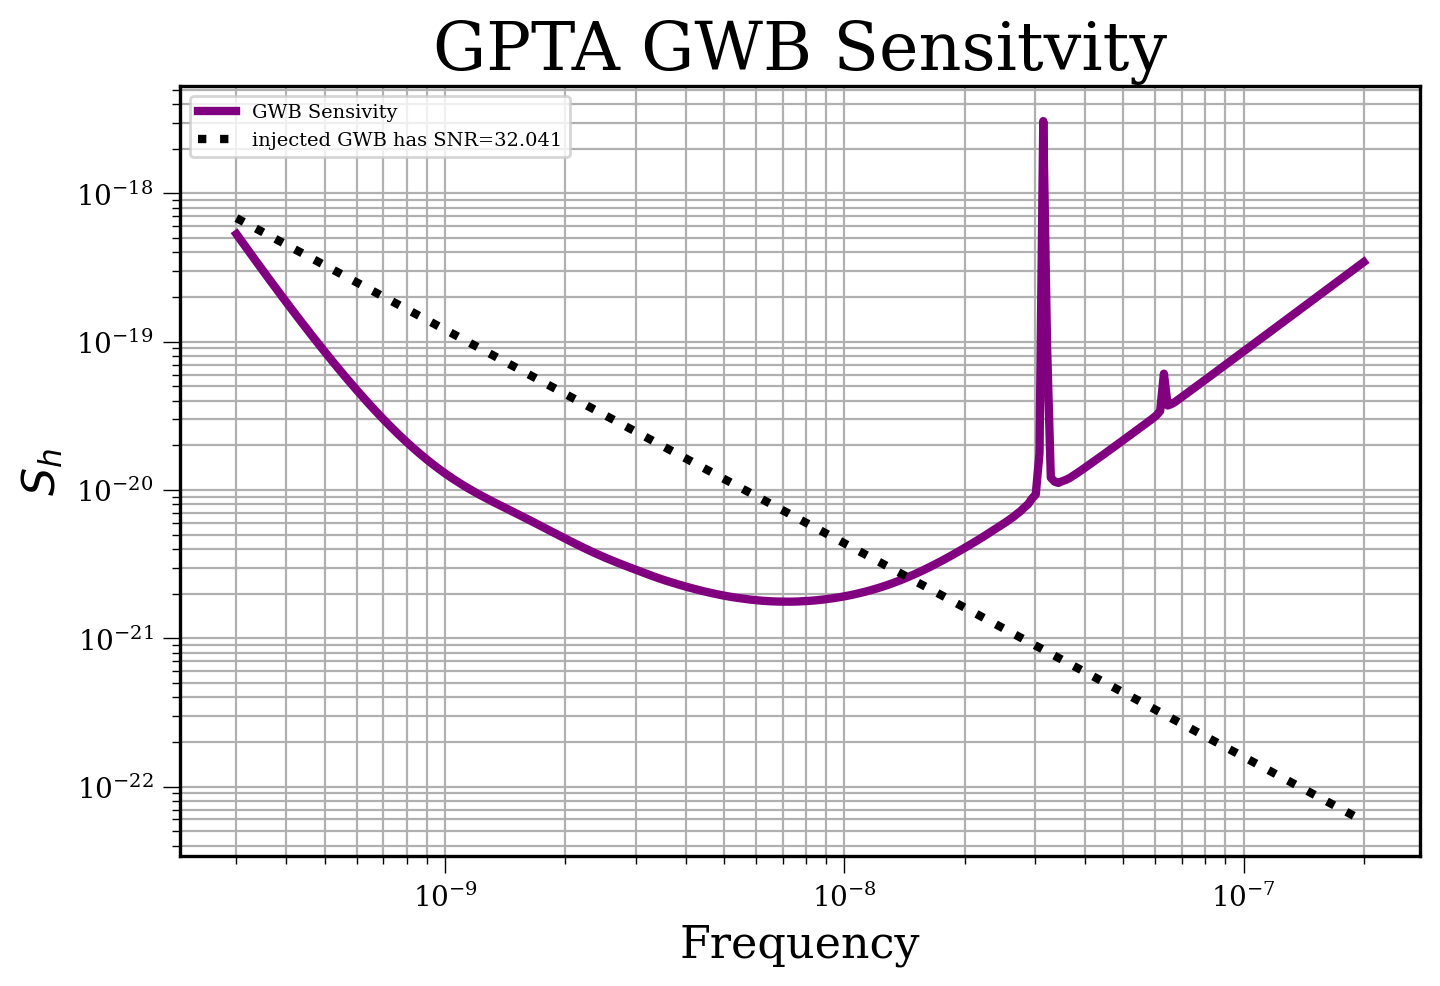

In [39]:
# Plot GWB SC
plt.figure(figsize=[8,5])
plt.loglog(full_GWBSC.freqs, full_GWBSC.S_eff,label="GWB Sensivity", color = "Purple", linewidth= 3)
plt.loglog(full_GWBSC.freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = gwb_label)
plt.legend(loc='upper left')
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('$S_h$', fontsize=16)
plt.title('GPTA GWB Sensitvity', fontsize = 24)
plt.grid(which='both')
plt.show()

# 2) Slice up the spectra

In [18]:
# test one slice at 16 years
test_psrs = gpta_psrs_40yrs
test_slice = get_sliced_spectra(
    psrs=test_psrs,
    start_mjd=-1000,
    end_mjd=15.8*365.25
    )
# confirm that it has SNR ~ 6.9
test_GWBSC = hsen.GWBSensitivityCurve(spectra=test_slice, orf='hd', autocorr=False)
test_GPTA_GWB_SNR = test_GWBSC.SNR(S_h)
gwb_label = f"injected GWB has SNR={test_GPTA_GWB_SNR:.3f}"
print(f"GPTA GWB SNR {test_GPTA_GWB_SNR:.2f} with {len(test_slice)} psrs.")

PTA spectrum with 115 psrs created.
GPTA GWB SNR 6.73 with 115 psrs.


Sensitivity is approximately the same as the the unfiltered tuning! (cf `creating_pta.ipynb`)

In [40]:
# take one slice every year from NG15 to the end of the data set (40yrs)
start = 16
end = 40
slice_cad = 1
yearly_years = np.linspace(start, end, (end-start)*slice_cad+1)

In [41]:
yearly_years

array([16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.])

In [42]:
yearly_spectra = []
yearly_GWBSC = []
yearly_SNR = [] 
for year in yearly_years:
    #print("got first spectra")
    yearly_spectra.append(
        get_sliced_spectra(
            psrs=gpta_psrs_40yrs,
            start_mjd=-1000,
            end_mjd=365.25*year
        )
    )
    yearly_GWBSC.append(hsen.GWBSensitivityCurve(spectra=yearly_spectra[-1], orf='hd', autocorr=False))
    yearly_SNR.append(yearly_GWBSC[-1].SNR(S_h))

PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 117 psrs created.
PTA spectrum with 119 psrs created.
PTA spectrum with 121 psrs created.
PTA spectrum with 123 psrs created.
PTA spectrum with 125 psrs created.
PTA spectrum with 127 psrs created.
PTA spectrum with 129 psrs created.
PTA spectrum with 131 psrs created.
PTA spectrum with 133 psrs created.
PTA spectrum with 135 psrs created.
PTA spectrum with 137 psrs created.
PTA spectrum with 139 psrs created.
PTA spectrum with 141 psrs created.
PTA spectrum with 143 psrs created.
PTA spectrum with 144 psrs created.
PTA spectrum with 145 psrs created.
PTA spectrum with 148 psrs created.
PTA spectrum with 149 psrs created.
PTA spectrum with 152 psrs created.


In [94]:
# color_map = plt.cm.jet_r(np.linspace(0,1,len(yearly_years)))
color_map = sns.cubehelix_palette(as_cmap=False, n_colors=len(yearly_years),reverse=False, 
                                  start=0.5, dark=0, light=0.5, rot=0.5, gamma=0.5)
color_map = sns.color_palette('viridis_r', n_colors = len(yearly_years), as_cmap=False,)
#color_map = sns.dark_palette(cbind[3], as_cmap=False, n_colors=len(yearly_years), reverse=True)
#color_map = sns.color_palette('coolwarm', as_cmap=False, n_colors=len(yearly_years))
#sns.diverging_palette(145, 300, s=60, as_cmap=True, center='dark',) #)n_colors=len(yearly_years))



In [95]:
color_map

[(0.906311, 0.894855, 0.098125),
 (0.804182, 0.882046, 0.114965),
 (0.699415, 0.867117, 0.175971),
 (0.595839, 0.848717, 0.243329),
 (0.496615, 0.826376, 0.306377),
 (0.404001, 0.800275, 0.362552),
 (0.327796, 0.77398, 0.40664),
 (0.252899, 0.742211, 0.448284),
 (0.19109, 0.708366, 0.482284),
 (0.146616, 0.67305, 0.508936),
 (0.123444, 0.636809, 0.528763),
 (0.120092, 0.600104, 0.54253),
 (0.128729, 0.563265, 0.551229),
 (0.140536, 0.530132, 0.555659),
 (0.154815, 0.493313, 0.55784),
 (0.169646, 0.456262, 0.55803),
 (0.185556, 0.41857, 0.556753),
 (0.203063, 0.379716, 0.553925),
 (0.221989, 0.339161, 0.548752),
 (0.239346, 0.300855, 0.540844),
 (0.257322, 0.25613, 0.526563),
 (0.271828, 0.209303, 0.504434),
 (0.280868, 0.160771, 0.472899),
 (0.283091, 0.110553, 0.431554),
 (0.277941, 0.056324, 0.381191)]

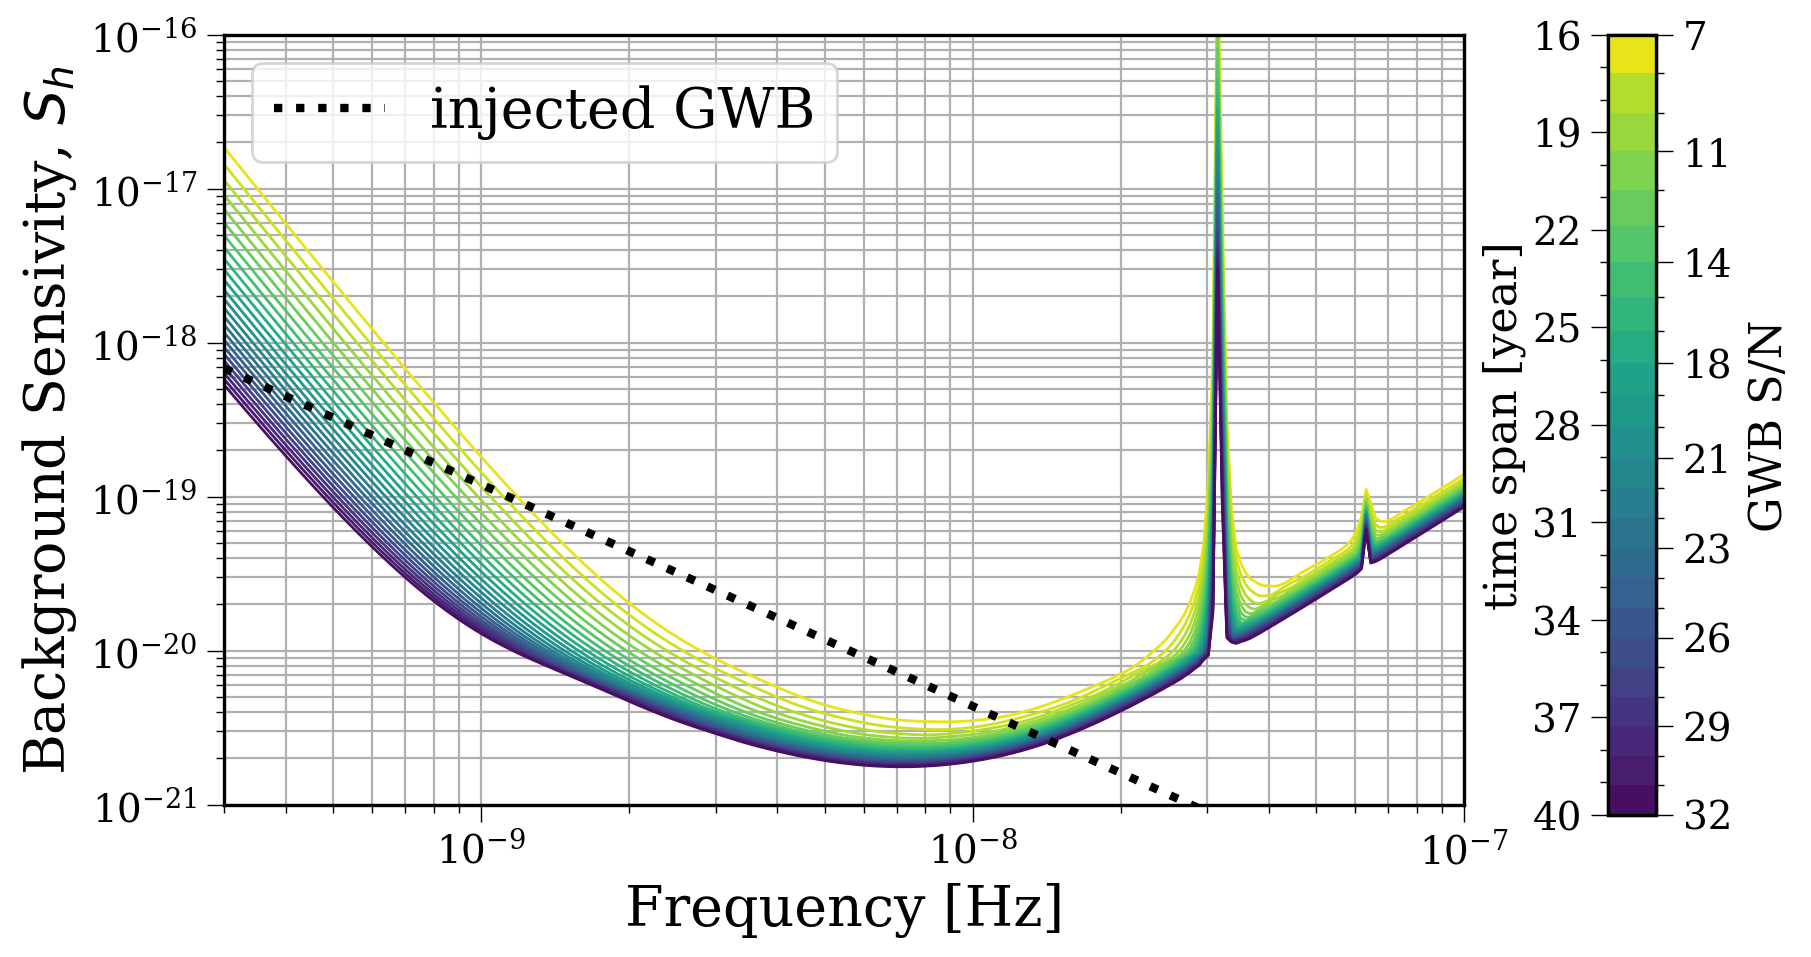

In [98]:
# Plot GWB SC
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', np.flip(color_map, axis=0), len(color_map))
fig = plt.figure(figsize=[8,5])
for i, sc in enumerate(yearly_GWBSC):
    linewidth=1
    if yearly_years[i] == yearly_years[-1] or yearly_years[i]==yearly_years[0]:
        #plt.loglog(sc.freqs, sc.S_eff,label=f"{yearly_years[i]:.1f}yr->GWB S/N: {yearly_SNR[i]:.2f}", color = color_map[i], linewidth=linewidth, alpha=1)
        plt.loglog(sc.freqs, sc.S_eff, color = color_map[i], linewidth=linewidth, alpha=1)
    else:
        plt.loglog(sc.freqs, sc.S_eff, color = color_map[i], linewidth=linewidth, alpha=1)
plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
plt.legend(loc='upper left', fontsize=20,) #colors=[color_map[0], color_map[-1]],)
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Background Sensivity, $S_h$', fontsize=20)
plt.ylim((1e-21, 1e-16))
plt.xlim((3e-10,1e-7))
plt.grid(which='both')
ax2 = fig.add_axes([0.99, 0.1, 0.03, 0.78])
#ax2a = ax2.twinx()
#ax2b = ax2.twinx()
norm = mpl.colors.BoundaryNorm(np.flip(yearly_years), cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(yearly_years))
norm = mpl.colors.BoundaryNorm(np.flip(yearly_SNR), cmap.N)
ax2b = cbar.ax.twinx()
mpl.colorbar.ColorbarBase(ax2b, cmap=cmap,
    spacing='proportional', format='%.0f', norm=norm, boundaries=np.flip(yearly_SNR))
ax2.set_ylabel('GWB S/N', fontsize=16, labelpad=33)
ax2b.set_ylabel('time span [year]', fontsize=16, labelpad=-90)
#plt.savefig(f'{fig_dir}/GPTA_40yr_gwb_evolution.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [99]:
sky_maps = [hsky.SkySensitivity(spectra=spectrum, theta_gw=theta_gw, phi_gw=phi_gw) for spectrum in yearly_spectra]

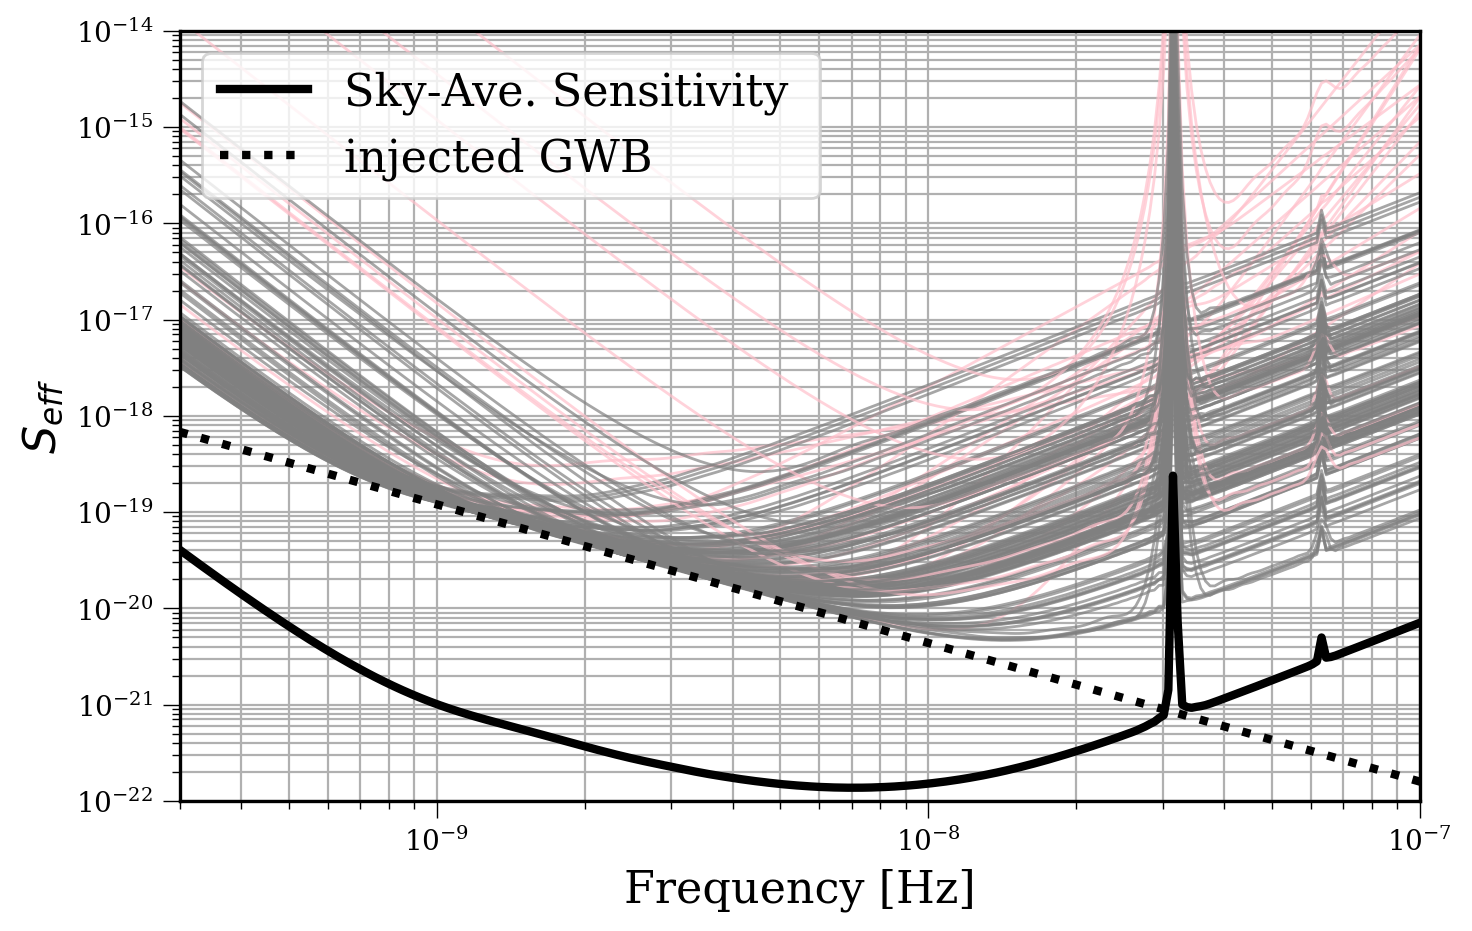

In [60]:
# Plot GWB SC
color_map = sns.color_palette('viridis_r', n_colors = len(yearly_years), as_cmap=False,)
plt.figure(figsize=[8,5])
for i, spec in enumerate(yearly_spectra[-1][:]):
    linewidth=1
    if gpta_psrs_40yrs[i].A_rn == 1e-20:
        plt.loglog(sc.freqs, spec.S_I, color = "grey", linewidth=linewidth, alpha=0.7)
    else:
       plt.loglog(sc.freqs, spec.S_I, color = "pink", linewidth=linewidth, alpha=0.7) 
plt.loglog(freqs, np.mean(sky_maps[-1].S_effSky, axis=1), color = "black", alpha=1, label="Sky-Ave. Sensitivity ", linewidth=3)
plt.loglog(freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
plt.legend(loc='upper left', fontsize=16,)
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('$S_{eff}$', fontsize=16)
#plt.title('GPTA Sky-Aved. Sensitivity @40yrs', fontsize = 24)
plt.xlim((freqs[0], 1e-7))
plt.ylim((1e-22,1e-14))
plt.grid(which='both')
#plt.savefig(f'{fig_dir}/all_pulsars_sensivity_curves.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

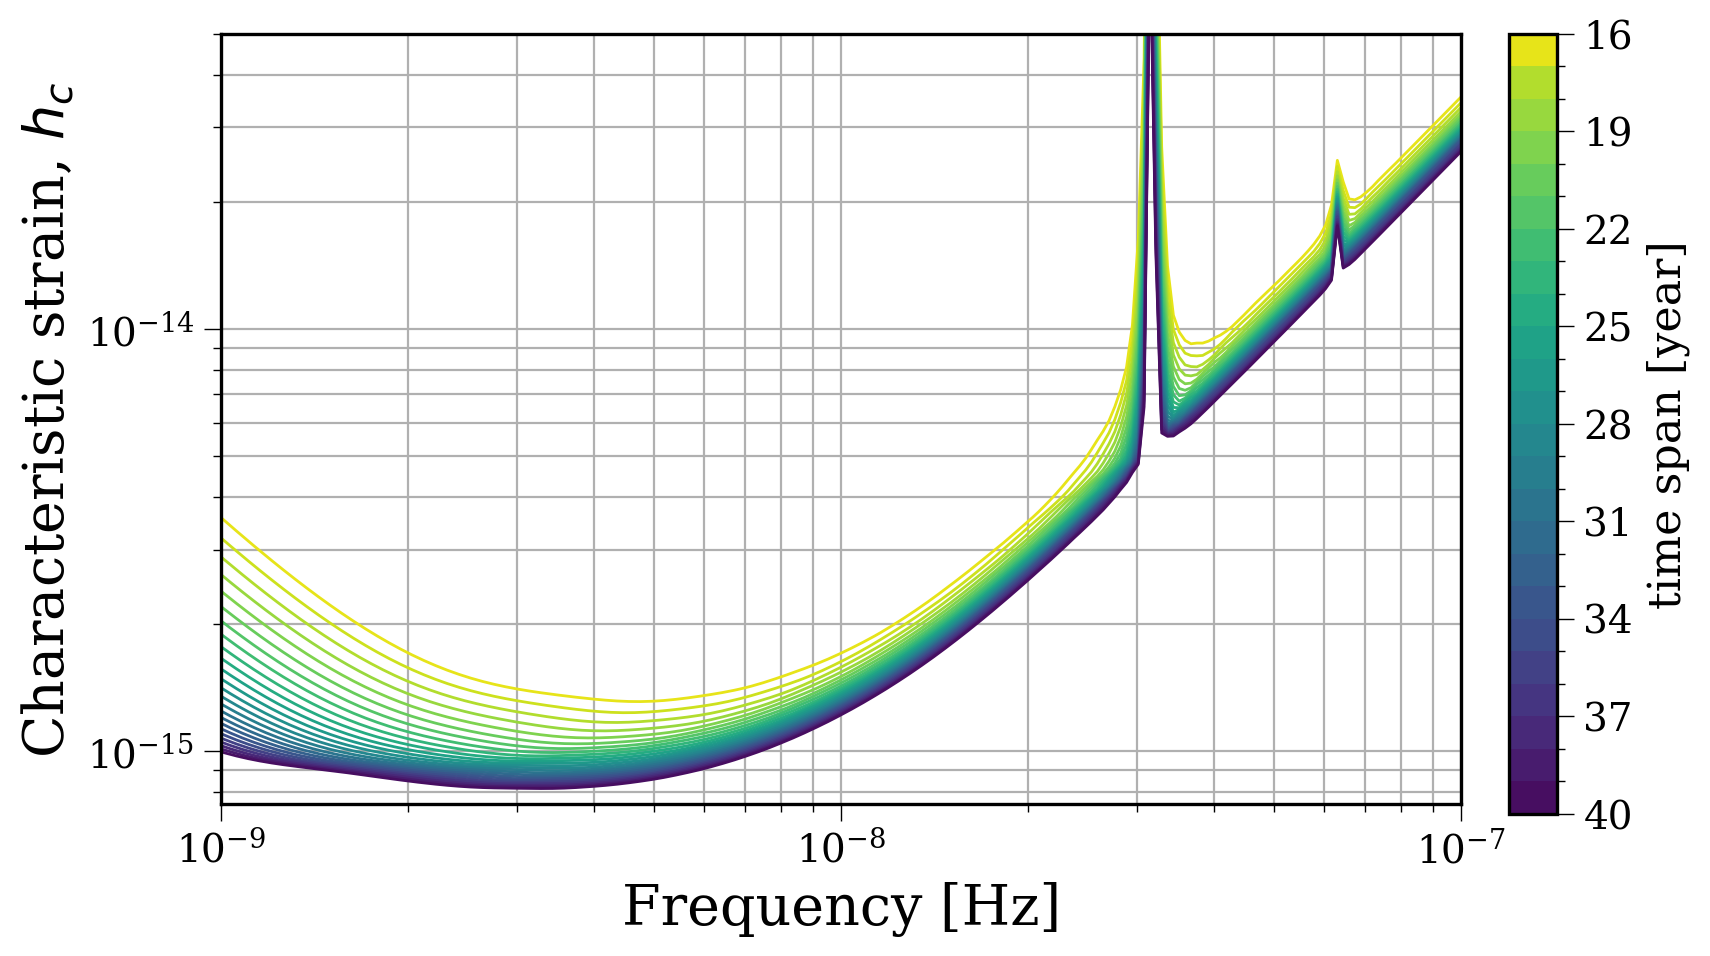

In [102]:
# Plot GWB SC
color_map = sns.color_palette('viridis_r', n_colors = len(yearly_years), as_cmap=False,)
fig = plt.figure(figsize=[8,5])
for i, sc in enumerate(sky_maps):
    linewidth=1
    if yearly_years[i] == 16.0 or yearly_years[i]==40.0: #or yearly_years[i]==40.0:
        plt.loglog(sc.freqs, np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1)
        #plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"{yearly_years[i]:.1f} years", color = color_map[i], linewidth=linewidth, alpha=1)
        #plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"{yearly_years[i]:.1f}yr->GWB SNR:{yearly_SNR[i]:.2f}", color = color_map[i], linewidth=linewidth, alpha=1)
    else:
        plt.loglog(sc.freqs, np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1)
#plt.legend(loc='upper left', fontsize=16,)
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Characteristic strain, $h_c$', fontsize=20)
plt.xlim((1e-9,1e-7))
plt.ylim((3e-15/4,2e-13/4))
#plt.title('GPTA Sky-Aved. Sensitivity', fontsize = 24)
plt.grid(which='both')
#### color bar
ax2 = fig.add_axes([0.93, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(np.flip(yearly_years), cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(yearly_years))
ax2.set_ylabel('time span [year]', fontsize=16,labelpad=5)
####
#plt.savefig(f'{fig_dir}/GPTA_40yr_hc_evolution.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

# 3) Define some sources for us to test sensitivity with.

In [64]:
# sources
#mass in Msun, D_L in Mpc, f(_GW?) in Hz
s1 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=7e-10).to('')
s2 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=4e-9).to('')
s3 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=1.15e-8).to('')
s4 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=2.8e-8).to('')
source_h0s = [s1.value, s2.value, s3.value, s4.value]
#h0_freqs = [7e-10, 4e-9, 1.15e-8, 2.8e-8] 
# swapping to the below since they fit our curve better?
h0_freqs = [2e-9, 5e-9, 2e-8, 4e-8]
source_freqs = [np.argmin(abs(freqs-h0_freqs[i])) for i in range(len(h0_freqs))]
cbind = sns.color_palette("colorblind")
source_colors = [cbind[0], cbind[2], cbind[6], cbind[8], cbind[-1]] 
source_h0s

[2.7443824468119924e-15,
 8.77174370311675e-15,
 1.7735543416856256e-14,
 3.2098491819673166e-14]

# Source Properties
|Source Name| Mass [ Msun ] | $L_\text{D}$ [Log10 Mpc] | $f_{\text{GW}}$ [Log10 Hz] | $h_0$ [ ] |
|:---:|:---:|:---:|:-------:|:----:| 
|S1 | $10^9$ | $3.2$ | -10.8 | 2.7e-15 |
|S2 | $10^9$ | $3.2$  | -9.4 | 8.7e-15 |
|S3 | $10^9$ | $3.2$ | -8.15 | 1.77e-15 |
|S4 | $10^9$ | $3.2$ | -8.28 | 3.2e-14 |

referencing [Liu et al.](https://iopscience-iop-org.oregonstate.idm.oclc.org/article/10.3847/1538-4357/acb492/pdf)

# 4) What if we drop worst pulsars and increase cadence on best pulsars?

### how to define worst? lowest sigma value? or smallest impact to sensitivity?

In [65]:
# this bit of code goes through 
hpsrs = reset_psrs()
end_year = 30.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
dropout_GWB = []
#mask_template = [True for i in range(len(spectra))]
for idx in range(len(spectra)):
    mask = [True for i in range(len(spectra))] 
    mask[idx] = False
    dropout_GWB.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))


Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.


In [66]:
#### run this to calculate the combinatorial gwb dropout (takes several hours)
# hpsrs = reset_psrs()
# end_year = 20.01
# spectra = np.array(get_sliced_spectra(
#         psrs=hpsrs,
#         start_mjd=-1000,
#         end_mjd=end_year*365.25
#         ))
# combinations = np.array(list(itertools.combinations(range(len(spectra)), 3)))
# dropout_GWB2 = []
# #mask_template = [True for i in range(len(spectra))]
# for idx_sets in combinations:
#     mask = [True for i in range(len(spectra))]
#     for idx in idx_sets:
#         mask[idx] = False
#     dropout_GWB2.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))

In [67]:
# save // load in the big combinatorial calculation
# with open(f'dropout_GWB2.pkl', 'wb') as fout:
#          pickle.dump(dropout_GWB2, fout, fix_imports=True)
with open(f'/home/baierj/projects/hasasia2/pta_sensitivity_tuning/data/dropout_GWB2.pkl', 'rb') as fin:
    dropout_GWB2 = pickle.load(fin)
dropout_GWB2_sorted = np.flip(np.sort(dropout_GWB2))

In [68]:
# get the actual pulsar combos we want.
hpsrs = reset_psrs()
end_year = 20.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
combinations = np.array(list(itertools.combinations(range(len(spectra)), 3)))
dropout_GWB2_sorted_filtered = []
for iidx in range(len(dropout_GWB2_sorted)):
    pass

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 115 psrs created.


In [69]:
start_year = 20
hpsrs = reset_psrs()
dropout_GWB_sorted = np.flip(np.sort(dropout_GWB))
idx_sorted = [dropout_GWB.index(el) for el in dropout_GWB_sorted]
idx_sorted_filtered = [ idx for idx in idx_sorted if min(hpsrs[idx].toas)<=start_year*yr_sec ]

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


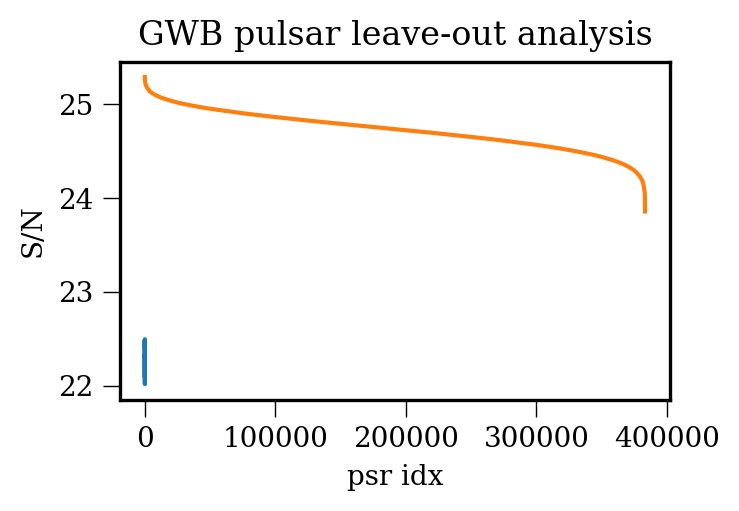

In [70]:
plt.plot(dropout_GWB)
plt.plot(dropout_GWB2_sorted)
plt.ylabel('S/N')
plt.title("GWB pulsar leave-out analysis")
plt.xlabel('psr idx')
plt.show()

In [71]:
# create modified campaign
hpsrs = reset_psrs()
#hpsrs = load_alpha_two_thirds_psrs()
start_year = 20
end_year = 30.01
cadence_factor = 4
pulsars_dropped_per_year = 3
iterations = 10

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


In [72]:
idx_best_to_worst = np.argsort([hpsrs[i].toaerrs[0] for i in range(len(hpsrs))])
# remove pulsars which come after the specified date
idx_best_to_worst_filtered = [ idx for idx in idx_best_to_worst if min(hpsrs[idx].toas)<=start_year*yr_sec ]
len(idx_best_to_worst_filtered)

119

In [73]:
hpsrs[idx_best_to_worst_filtered[0]].toaerrs[0], hpsrs[idx_best_to_worst_filtered[-1]].toaerrs[0] 

(1.5739376639465265e-07, 7.442768643424258e-06)

In [74]:
psrs_high_cad = idx_best_to_worst_filtered[:iterations]
psrs_removed = np.flip(idx_best_to_worst_filtered[-iterations*pulsars_dropped_per_year-1:])
psrs_high_cad, psrs_removed

([79, 53, 32, 3, 113, 77, 92, 102, 38, 82],
 array([ 56,  40,  68,  28,  43,  69, 153,  45,  46,  21,  33,  70,  24,
         41,  49,  10,  67,  88,  51,  62, 114,  47, 101,  35, 104, 105,
         71,  80,  22,  23,  89]))

In [75]:
# this is for the RMS removal analysis too.
GWBSCs = []
GWBSNRs = []
SNRs = []
SMs = []
hpsrs = reset_psrs()
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs.append(GWBSCs[-1].SNR(S_h))
SNRs.append([0.5*SMs[-1].SNR(h_0) for h_0 in source_h0s])
for i, psr_hcad in enumerate(psrs_high_cad): # # enumerate([psrs_high_cad[0]]):
    # "remove" pulsars with .filter_data() function
    print(f"{i+1})removing pulsars ", hpsrs[psrs_removed[i]].name, hpsrs[psrs_removed[i+1]].name, hpsrs[psrs_removed[i+2]].name)
    [hpsrs[psrs_removed[pulsars_dropped_per_year*i+idx]].filter_data(start_time=0, end_time=start_year*365.25) for idx in range(pulsars_dropped_per_year)]
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
    start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
    cadence=None, cadence_factor=cadence_factor, uneven=True,
    A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
    )
    print("toas after: ", len(hpsrs[psr_hcad].toas))
    # create psr spectra at end of cadence  
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
    SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs.append(GWBSCs[-1].SNR(S_h))
    SNRs.append([0.5*SMs[-1].SNR(h_0) for h_0 in source_h0s])


Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
1)removing pulsars  J0326+0145 J2028-0020 J1015+0331
quadrupuling pulsar  J1907-0212
toas before:  694
old: 694, new: 1293
toas after:  1293
PTA spectrum with 133 psrs created.
2)removing pulsars  J2028-0020 J1015+0331 J2100-0048
quadrupuling pulsar  J1900-0226
toas before:  562
old: 562, new: 1159
toas after:  1159
PTA spectrum with 133 psrs created.
3)removing pulsars  J1015+0331 J2100-0048 J1514-0303
quadrupuling pulsar  J2134-0018
toas before:  557
old: 557, new: 1156
toas after:  1156
PTA spectrum with 132 psrs created.
4)removing pulsars  J2100-0048 J1514-0303 J2154-0231
quadrupuling pulsar  J2053-0059
toas before:  643
old: 643, new: 1240
toas after:  1240
PTA spectrum with 132 psrs created.
5)removing pulsars  J1514-0303 J2154-0231 J1213+0422
quadrupuling pulsar  J2212-0045
toas before:  559
old: 559, new: 1156
toas after:  1156
PTA spectrum with 132 psrs created.
6)removing pulsars  J

In [76]:
# we can do this for the GWB dropout analysis too.
GWBSCs2 = []
GWBSNRs2 = []
SNRs2 = []
SMs2 = []
hpsrs = reset_psrs()
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs2.append(hsen.GWBSensitivityCurve(spectra))
SMs2.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs2.append(GWBSCs2[-1].SNR(S_h))
SNRs2.append([0.5*SMs2[-1].SNR(h_0) for h_0 in source_h0s])
for i, psr_hcad in enumerate(psrs_high_cad): # # enumerate([psrs_high_cad[0]]):
    # "remove" pulsars with .filter_data() function
    print(f"{i+1})removing pulsars ", hpsrs[idx_sorted_filtered[i]].name, hpsrs[idx_sorted_filtered[i+1]].name, hpsrs[idx_sorted_filtered[i+2]].name)
    [hpsrs[idx_sorted_filtered[pulsars_dropped_per_year*i+idx]].filter_data(start_time=0, end_time=start_year*365.25) for idx in range(pulsars_dropped_per_year)]
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
    start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
    cadence=None, cadence_factor=cadence_factor, uneven=True,
    A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
    )
    print("toas after: ", len(hpsrs[psr_hcad].toas))
    # create psr spectra at end of cadence  
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs2.append(hsen.GWBSensitivityCurve(spectra))
    SMs2.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs2.append(GWBSCs2[-1].SNR(S_h))
    SNRs2.append([0.5*SMs2[-1].SNR(h_0) for h_0 in source_h0s])

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
1)removing pulsars  J2223+0357 J0634+0328 J1015+0331
quadrupuling pulsar  J1907-0212
toas before:  694
old: 694, new: 1293
toas after:  1293
PTA spectrum with 133 psrs created.
2)removing pulsars  J0634+0328 J1015+0331 J0326+0145
quadrupuling pulsar  J1900-0226
toas before:  562
old: 562, new: 1159
toas after:  1159
PTA spectrum with 133 psrs created.
3)removing pulsars  J1015+0331 J0326+0145 J2154-0231
quadrupuling pulsar  J2134-0018
toas before:  557
old: 557, new: 1156
toas after:  1156
PTA spectrum with 133 psrs created.
4)removing pulsars  J0326+0145 J2154-0231 J1535-0011
quadrupuling pulsar  J2053-0059
toas before:  643
old: 643, new: 1240
toas after:  1240
PTA spectrum with 133 psrs created.
5)removing pulsars  J2154-0231 J1535-0011 J1135+0251
quadrupuling pulsar  J2212-0045
toas before:  559
old: 559, new: 1156
toas after:  1156
PTA spectrum with 133 psrs created.
6)removing pulsars  J

In [77]:
SNRs = []
for i in range(len(GWBSNRs)):
    SNRs.append([np.mean(SMs[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])
SNRs2 = []
for i in range(len(GWBSNRs2)):
    SNRs2.append([np.mean(SMs2[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])
src_snr = np.array(SNRs).T
src_snr2 = np.array(SNRs2).T
snr_3sig = 3.7145
detvol1 = np.array([calculate_detection_volume(SM,SNR_threshold=snr_3sig, frequency=freqs[source_freqs],M_c=1e9) for _, SM in enumerate(SMs)]).T
detvol2 = np.array([calculate_detection_volume(SM,SNR_threshold=snr_3sig, frequency=freqs[source_freqs],M_c=1e9) for _, SM in enumerate(SMs2)]).T

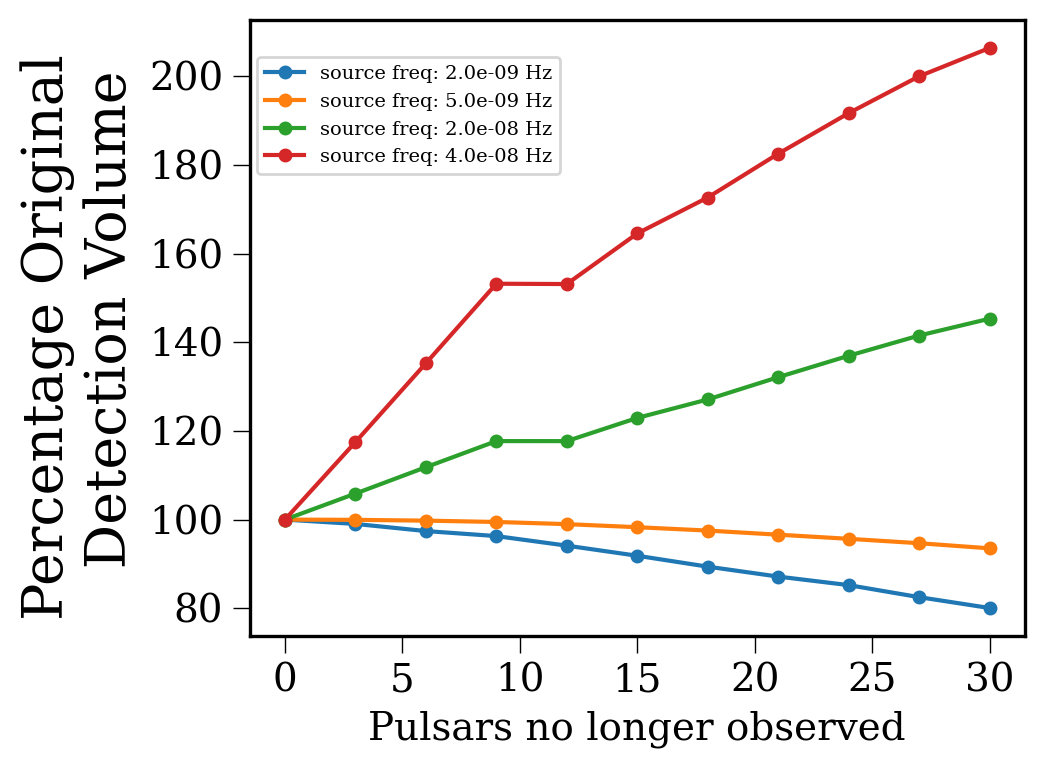

In [78]:
dropped = 3*np.array([i for i in range(0,len(SMs))])
fig = plt.figure(figsize=(5,4))
det_vol = detvol1
for i, key in enumerate(det_vol):
    plt.plot(dropped, 100*det_vol[i]/det_vol[i][0], marker='o', color=f"C{i}", label=f"source freq: {freqs[source_freqs[i]]:.1e} Hz")
#plt.title("Swapping 3psr for a x4 high cadence, yr 20->30")
plt.xlabel("Pulsars no longer observed", fontsize=14)
plt.ylabel("Percentage Original \n Detection Volume", fontsize=20)
plt.legend(loc=(0.01,0.75))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [79]:
dropped = 3* np.array([i for i in range(0,len(SNRs))])
#plt.plot(dropped, GWBSNRs, marker='o', color="purple", label='removing psrs by psr white noise')
plt.plot(dropped, GWBSNRs2, marker='o', color='purple', )#label='removing psrs by GWB leave out analysis')
#plt.title(f"GWB S/N swapping 3psr for a x4 high cadence for yrs {start_year}->{end_year}")
plt.xlabel("pulsars no longer observed", fontsize=12)
plt.ylabel("GWB S/N", fontsize=12)
#plt.legend()
plt.xticks()
plt.yticks()
#plt.savefig(f'{fig_dir}/psr_dropping_gwb_comp.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [80]:
dropped = 3* np.array([i for i in range(0,len(SNRs))])
plt.plot(dropped, GWBSNRs, marker='o', color="purple", label='removing psrs by psr white noise')
plt.plot(dropped, GWBSNRs2, marker='o', color='pink', label='removing psrs by GWB leave out analysis')
#plt.title(f"GWB S/N swapping 3psr for a x4 high cadence for yrs {start_year}->{end_year}")
plt.xlabel("pulsars no longer observed", fontsize=8)
plt.ylabel("GWB S/N", fontsize=8)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(f'{fig_dir}/psr_dropping_gwb_comp.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
# # Plot skymap SC
# color_map = plt.cm.jet_r(np.linspace(0,1,len(SMs)))
# plt.figure(figsize=[8,5])
# for i, sc in enumerate(SMs):
#     linewidth=1
#     plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"x{cadence_factor} cad to {dropped[i]/3:.0f}psrs", color = color_map[i], linewidth=linewidth, alpha=0.75)
# #plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
# for i in range(len(h0_freqs)):
#     plt.axvline(h0_freqs[i], linestyle='--', color=source_colors[i], linewidth=2)
# # plt.legend(
# #            loc='upper left', fontsize=10,
# #            )
# plt.xlabel('Frequency [Hz]', fontsize=16)
# plt.ylabel('$h_{c}$', fontsize=16)
# #plt.title(f'Sky-Aved. "white noise removal" @{end_year:.1f}yrs', fontsize = 24)
# plt.grid(which='both')
# plt.xlim((1e-9, 1e-7))
# plt.ylim((2e-15, 8e-13))
# plt.savefig(f'{fig_dir}/x4cad_rms_psr_drop.png', dpi=600, bbox_inches='tight', facecolor='white')
# plt.show()

In [81]:
f = ticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-3,3))
nhz = [int(h0_freqs[i]/1e-9) for i in range(4)] 
inset_legs = [mpatches.Patch(color=f"C{i}", label=r"$\rm f_{GW}$: "+"${}$ Hz".format(f.format_data(nhz[i]))) for i in range(len(SNRs[0]))]
#inset_legs = [mpatches.Patch(color=f"C{i}", label=r"$\rm f_{GW}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i]))) for i in range(len(SNRs[0]))]

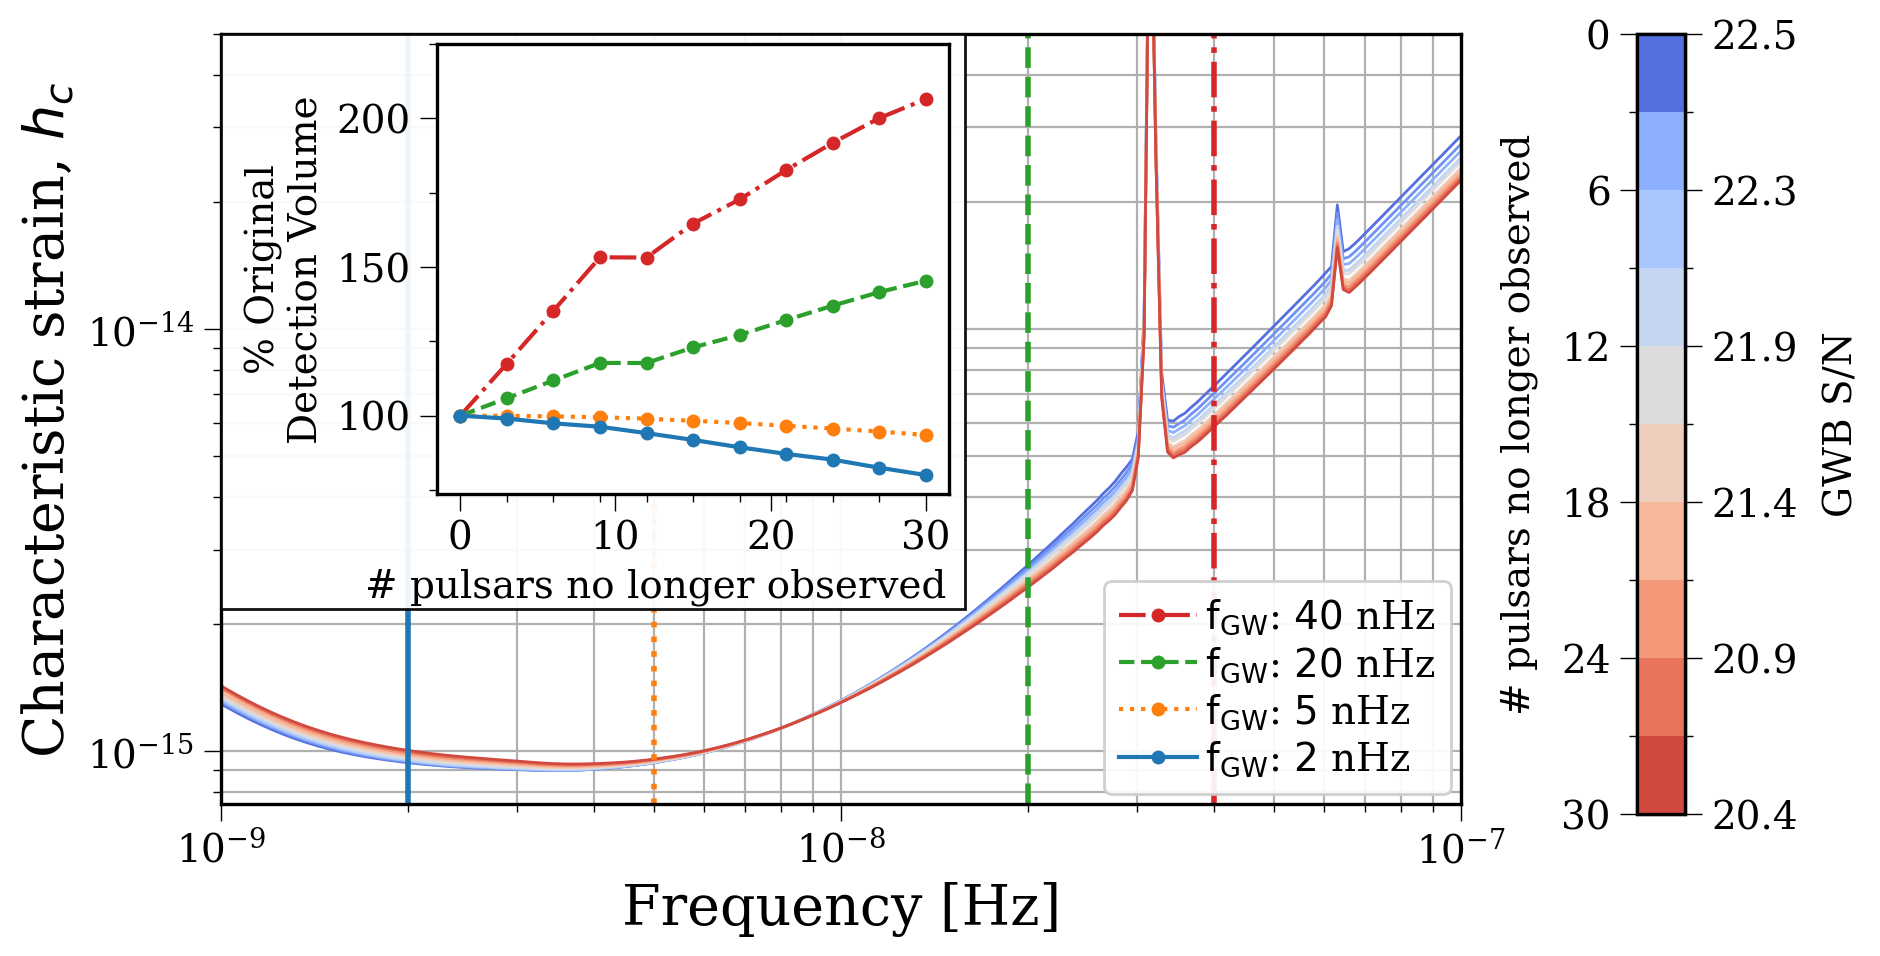

In [106]:
# Plot skymap SC
f = ticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-3,3))
dropped = pulsars_dropped_per_year*np.array([i for i in range(0,len(SNRs))])
color_map = sns.color_palette("coolwarm", as_cmap=False, n_colors=len(dropped))
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', np.flip(color_map, axis=0), len(color_map))
linestyles=['solid', 'dotted', 'dashed', 'dashdot']
fig = plt.figure(figsize=[8,5])
ax1 = fig.add_subplot(1,1,1,zorder=0)
for i, sc in enumerate(SMs):
    linewidth=1
    #plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"x{cadence_factor} cad to {dropped[i]/3:.0f}psrs", color = color_map[i], linewidth=linewidth, alpha=0.75)
    plt.loglog(sc.freqs, np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1.0)
plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
for i in range(len(h0_freqs)):
    plt.axvline(h0_freqs[i], linestyle=linestyles[i], color=f'C{i}', linewidth=2, )#label=r"$\rm f_{GW}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])))
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Characteristic strain, $h_{c}$', fontsize=20)
plt.grid(which='both')
plt.xlim((1e-9, 1e-7))
plt.ylim((3e-15/4, 2e-13/4))
plt.legend(handles=ax3.get_children()[0:4], loc=(0.712,0.0125), fontsize=14,framealpha=0.925, labelspacing=0.2, handletextpad=0.2)
# the below is a legend just to shade out the region behind the plot
#plt.legend([],bbox_to_anchor=(.01, 0.99), loc='upper left', facecolor='white', fancybox=True, borderpad=16)#borderpad=10)
loc_box = [0.0, 0.253, 0.6, 1-0.253]
buffer=0.0
#### make the inset plot background
ax1.add_patch(plt.Rectangle((
    loc_box[0]-buffer, loc_box[1]-buffer,), 
    loc_box[2]+buffer, loc_box[3]+buffer, 
    linestyle="-", edgecolor="k", facecolor="w", 
    linewidth=1, alpha=0.93,zorder=21, #zorder=5, 
    transform=ax1.transAxes))
left, bottom, width, height = [0.26, 0.42, 0.32, 0.45]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.plot()
for i in np.flip(range(len(SNRs[0]))):
    ax3.plot(dropped, 100*detvol1[i]/detvol1[i][0], marker='o', color=f"C{i}", label=r"$\rm f_{GW}$: "+"${}$ nHz".format(nhz[i]), linestyle=linestyles[i])
    # ax3.plot(dropped, 100*src_snr[i]/src_snr[i][0], marker='o', color=f'C{i}',#color=source_colors[i],
    #          label="$f_{gw}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])))
ax3.set_xlabel('# pulsars no longer observed      ', fontsize=14)
ax3.set_ylabel("% Original\nDetection Volume", fontsize=14)
ax3.set_yticks([75,100,125,150,175,200,225],minor=True)
ax3.set_xticks(dropped,minor=True)
# ax3.set_xticks()
#ax3.legend(fontsize=6)
#### make the color bar
ax2 = fig.add_axes([1.01, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(np.flip(dropped), cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(dropped),ticklocation='right')
#ax2.set_ylabel('# pulsars no longer observed', fontsize=12)
ax2b = cbar.ax.twinx()
norm = mpl.colors.BoundaryNorm(np.flip(GWBSNRs), cmap.N)
mpl.colorbar.ColorbarBase(ax2b, cmap=cmap, format='%.1f', norm=norm, boundaries=np.flip(GWBSNRs))
ax2.set_ylabel('GWB S/N', fontsize=14, labelpad=50)
ax2b.set_ylabel('# pulsars no longer observed', fontsize=14, labelpad=-107)
for label in ax2.get_yticklabels(minor=True):
    label.set_verticalalignment('center')
#plt.savefig(f'{fig_dir}/x4cad_rms_psr_drop.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

In [86]:
# # Plot skymap SC
# f = ticker.ScalarFormatter(useMathText=True)
# f.set_powerlimits((-3,3))
# dropped = pulsars_dropped_per_year*np.array([i for i in range(0,len(SNRs2))])
# color_map = sns.color_palette("coolwarm", as_cmap=False, n_colors=len(dropped))
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', np.flip(color_map, axis=0), len(color_map))
# fig = plt.figure(figsize=[8,5])
# for i, sc in enumerate(SMs2):
#     linewidth=1
#     #plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"x{cadence_factor} cad to {dropped[i]/3:.0f}psrs", color = color_map[i], linewidth=linewidth, alpha=0.75)
#     plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1.0)
# #plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
# for i in range(len(h0_freqs)):
#     plt.axvline(h0_freqs[i], linestyle='--', color=f'C{i}', linewidth=2)
# plt.xlabel('Frequency [Hz]', fontsize=14)
# plt.ylabel('Characteristic strain, $h_{c}$', fontsize=14)
# plt.grid(which='both')
# plt.xlim((1e-9, 1e-7))
# plt.ylim((3e-15, 2e-13))
# # the below is a legend just to shade out the region behind the plot
# plt.legend([],bbox_to_anchor=(.01, 0.99), loc='upper left', facecolor='white', fancybox=True, borderpad=16)#borderpad=10)
# #### make the inset plot
# left, bottom, width, height = [0.215, 0.35, 0.3, 0.45]
# ax3 = fig.add_axes([left, bottom, width, height])
# ax3.plot()
# for i in np.flip(range(len(SNRs2[0]))):
#     ax3.plot(dropped, 100*src_snr2[i]/src_snr2[i][0], marker='o', color=f'C{i}',#color=source_colors[i],
#              label="$f_{gw}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])))
# ax3.set_xlabel('# pulsars no longer observed', fontsize=8)
# ax3.set_ylabel("% standard campaign S/N", fontsize=8)
# ax3.legend(fontsize=6)
# #### make the color bar
# ax2 = fig.add_axes([0.99, 0.1, 0.03, 0.78])
# norm = mpl.colors.BoundaryNorm(np.flip(dropped), cmap.N)
# cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
#     spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(dropped),ticklocation='right')
# #ax2.set_ylabel('# pulsars no longer observed', fontsize=12)
# ax2b = cbar.ax.twinx()
# norm = mpl.colors.BoundaryNorm(np.flip(GWBSNRs2), cmap.N)
# mpl.colorbar.ColorbarBase(ax2b, cmap=cmap, format='%.1f', norm=norm, boundaries=np.flip(GWBSNRs2))
# ax2.set_ylabel('GWB S/N', fontsize=12, labelpad=37)
# ax2b.set_ylabel('# pulsars no longer observed', fontsize=12, labelpad=-87)
# for label in ax2.get_yticklabels(minor=True):
#     label.set_verticalalignment('center')
# plt.savefig(f'{fig_dir}/x4cad_gwb_psr_drop.pdf', dpi=600, bbox_inches='tight', facecolor='white')
# plt.show()
# plt.close()

In [108]:
# Plot skymap SC
f = ticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-3,3))
dropped = pulsars_dropped_per_year*np.array([i for i in range(0,len(SNRs2))])
color_map = sns.color_palette("coolwarm", as_cmap=False, n_colors=len(dropped))
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', np.flip(color_map, axis=0), len(color_map))
linestyles=['solid', 'dotted', 'dashed', 'dashdot']
fig = plt.figure(figsize=[8,5])
ax1 = fig.add_subplot(1,1,1,zorder=0)
for i, sc in enumerate(SMs2):
    linewidth=1
    #plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"x{cadence_factor} cad to {dropped[i]/3:.0f}psrs", color = color_map[i], linewidth=linewidth, alpha=0.75)
    plt.loglog(sc.freqs, np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1.0)
plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
for i in range(len(h0_freqs)):
    plt.axvline(h0_freqs[i], linestyle=linestyles[i], color=f'C{i}', linewidth=2, )#label=r"$\rm f_{GW}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])))
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Characteristic strain, $h_{c}$', fontsize=20)
plt.grid(which='both')
plt.xlim((1e-9, 1e-7))
plt.ylim((3e-15/4, 2e-13/4))
plt.legend(handles=ax3.get_children()[0:4], loc=(0.712,0.0125), fontsize=14,framealpha=0.925, labelspacing=0.2, handletextpad=0.2)
# the below is a legend just to shade out the region behind the plot
#plt.legend([],bbox_to_anchor=(.01, 0.99), loc='upper left', facecolor='white', fancybox=True, borderpad=16)#borderpad=10)
loc_box = [0.0, 0.253, 0.6, 1-0.253]
buffer=0.0
#### make the inset plot background
ax1.add_patch(plt.Rectangle((
    loc_box[0]-buffer, loc_box[1]-buffer,), 
    loc_box[2]+buffer, loc_box[3]+buffer, 
    linestyle="-", edgecolor="k", facecolor="w", 
    linewidth=1, alpha=0.93,zorder=21, #zorder=5, 
    transform=ax1.transAxes))
left, bottom, width, height = [0.26, 0.42, 0.32, 0.45]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.plot()
for i in np.flip(range(len(SNRs2[0]))):
    ax3.plot(dropped, 100*detvol2[i]/detvol2[i][0], marker='o', color=f"C{i}", label=r"$\rm f_{GW}$: "+"${}$ nHz".format(nhz[i]), linestyle=linestyles[i])
    # ax3.plot(dropped, 100*src_snr[i]/src_snr[i][0], marker='o', color=f'C{i}',#color=source_colors[i],
    #          label="$f_{gw}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])))
ax3.set_xlabel('# pulsars no longer observed      ', fontsize=14)
ax3.set_ylabel("% Original\nDetection Volume", fontsize=14)
ax3.set_yticks([75,100,125,150,175,200,225],minor=True)
ax3.set_xticks(dropped,minor=True)
# ax3.set_xticks()
#ax3.legend(fontsize=6)
#### make the color bar
ax2 = fig.add_axes([1.01, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(np.flip(dropped), cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(dropped),ticklocation='right')
#ax2.set_ylabel('# pulsars no longer observed', fontsize=12)
ax2b = cbar.ax.twinx()
norm = mpl.colors.BoundaryNorm(np.flip(GWBSNRs2), cmap.N)
mpl.colorbar.ColorbarBase(ax2b, cmap=cmap, format='%.1f', norm=norm, boundaries=np.flip(GWBSNRs2))
ax2.set_ylabel('GWB S/N', fontsize=14, labelpad=50)
ax2b.set_ylabel('# pulsars no longer observed', fontsize=14, labelpad=-105)
for label in ax2.get_yticklabels(minor=True):
    label.set_verticalalignment('center')
#plt.savefig(f'{fig_dir}/x4cad_gwb_psr_drop.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

In [103]:
# # Plot skymap SC
# #color_map = plt.cm.jet_r(np.linspace(0,1,len(SMs)))
# # f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
# # g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# # fmt = mpl.ticker.FuncFormatter(g)
# import matplotlib.ticker as mticker
# f = mticker.ScalarFormatter(useMathText=True)
# f.set_powerlimits((-3,3))
# dropped = pulsars_dropped_per_year*np.array([i for i in range(0,len(SNRs2))])
# color_map = sns.color_palette("coolwarm", as_cmap=False, n_colors=len(dropped))
# #color_map = sns.diverging_palette(10, 250, as_cmap=False, n = len(dropped), center='dark')
# #color_map = sns.dark_palette("seagreen", as_cmap=False, n_colors=len(dropped))
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', np.flip(color_map, axis=0), len(color_map))
# fig = plt.figure(figsize=[8,5])
# for i, sc in enumerate(SMs2):
#     linewidth=1
#     #plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"x{cadence_factor} cad to {dropped[i]/3:.0f}psrs", color = color_map[i], linewidth=linewidth, alpha=0.75)
#     plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1.0)
# #plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
# for i in range(len(h0_freqs)):
#     plt.axvline(h0_freqs[i], linestyle='--', color=f'C{i}', linewidth=2)
# # plt.legend(
# #            loc='upper left', fontsize=10,
# #            )
# plt.xlabel('Frequency [Hz]', fontsize=16)
# plt.ylabel('$h_{c}$', fontsize=16)
# #plt.title(f'Sky-Aved. "white noise removal" @{end_year:.1f}yrs', fontsize = 24)
# plt.grid(which='both')
# plt.xlim((1e-9, 1e-7))
# plt.ylim((3e-15, 2e-13))
# #plt.legend([],loc=(0.07, 0.22), prop={'size':275}, alpha=0.75)
# plt.legend([],bbox_to_anchor=(.01, 0.99), loc='upper left', facecolor='white', fancybox=True, borderpad=16)#borderpad=10)
# #### make the inset plot
# left, bottom, width, height = [0.215, 0.35, 0.3, 0.45]
# ax3 = fig.add_axes([left, bottom, width, height])
# ax3.plot()
# for i in range(len(SNRs[0])):
#     ax3.plot(dropped, 100*src_snr2[i]/src_snr2[i][0], marker='o', color=f'C{i}',#color=source_colors[i],
#              label="source freq: {} Hz".format(f.format_data(h0_freqs[i]))) 
#              #label="source freq: {}Hz".format(fmt(source_freqs[i])))
#             #    "\\num{{{0:.2g}}}".format
#             #label=f"source freq: {freqs[source_freqs[i]]:.1e} Hz")
# ax3.set_xlabel('# pulsars no longer observed', fontsize=8)
# ax3.set_ylabel("% standard campaign S/N", fontsize=8)
# ax3.legend()
# #### make the color bar
# ax2 = fig.add_axes([0.93, 0.1, 0.03, 0.78])
# norm = mpl.colors.BoundaryNorm(np.flip(dropped), cmap.N)
# cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
#     spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(dropped),ticklocation='right')
# ax2.set_ylabel('# pulsars no longer observed', fontsize=12)
# for label in ax2.get_yticklabels(minor=True):
#     label.set_verticalalignment('center')
# plt.savefig(f'{fig_dir}/x4cad_gwb_psr_drop.png', dpi=600, bbox_inches='tight', facecolor='white')
# plt.show()
# plt.close()

In [104]:
# # Plot skymap SC
# color_map = plt.cm.jet_r(np.linspace(0,1,len(SMs)))
# plt.figure(figsize=[8,5])
# for i, sc in enumerate(SMs2):
#     linewidth=1
#     plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"x{cadence_factor} cad to {dropped[i]/3:.0f}psrs", color = color_map[i], linewidth=linewidth, alpha=0.75)
# #plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
# for i in range(len(h0_freqs)):
#     plt.axvline(h0_freqs[i], linestyle='--', color=f'C{i}', linewidth=2)
# plt.legend(
#            loc='upper left', fontsize=10,
#            )
# plt.xlabel('Frequency [Hz]', fontsize=16)
# plt.ylabel('$h_{c}$', fontsize=16)
# #plt.title(f'Sky-Aved. "leave out removal" @{end_year:.1f}yrs', fontsize = 24)
# plt.grid(which='both')
# plt.xlim((4e-10, 1e-7))
# plt.ylim((2e-15, 8e-13))
# plt.savefig(f'{fig_dir}/4xcad_gwb_psr_drop.png', dpi=600, bbox_inches='tight', facecolor='white')
# plt.show()

In [105]:
# src_snr = np.array(SNRs).T
# dropped = 3*np.array([i for i in range(1,len(GWBSNRs)+1)])
# print(len(dropped))
# for i in range(len(SNRs[0])):
#     plt.plot(dropped, 100*src_snr[i]/src_snr[i][0], marker='o', color=f"C{i}", label=f"source freq: {freqs[source_freqs[i]]:.1e} Hz")
# #plt.title("Source S/N swapping 3psr for a x4 high cadence, yr 20->30")
# plt.xlabel("Pulsars no longer observed", fontsize=14)
# plt.ylabel("% standard campaign S/N", fontsize=16)
# plt.legend(loc=(0.01,0.70))
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.show()

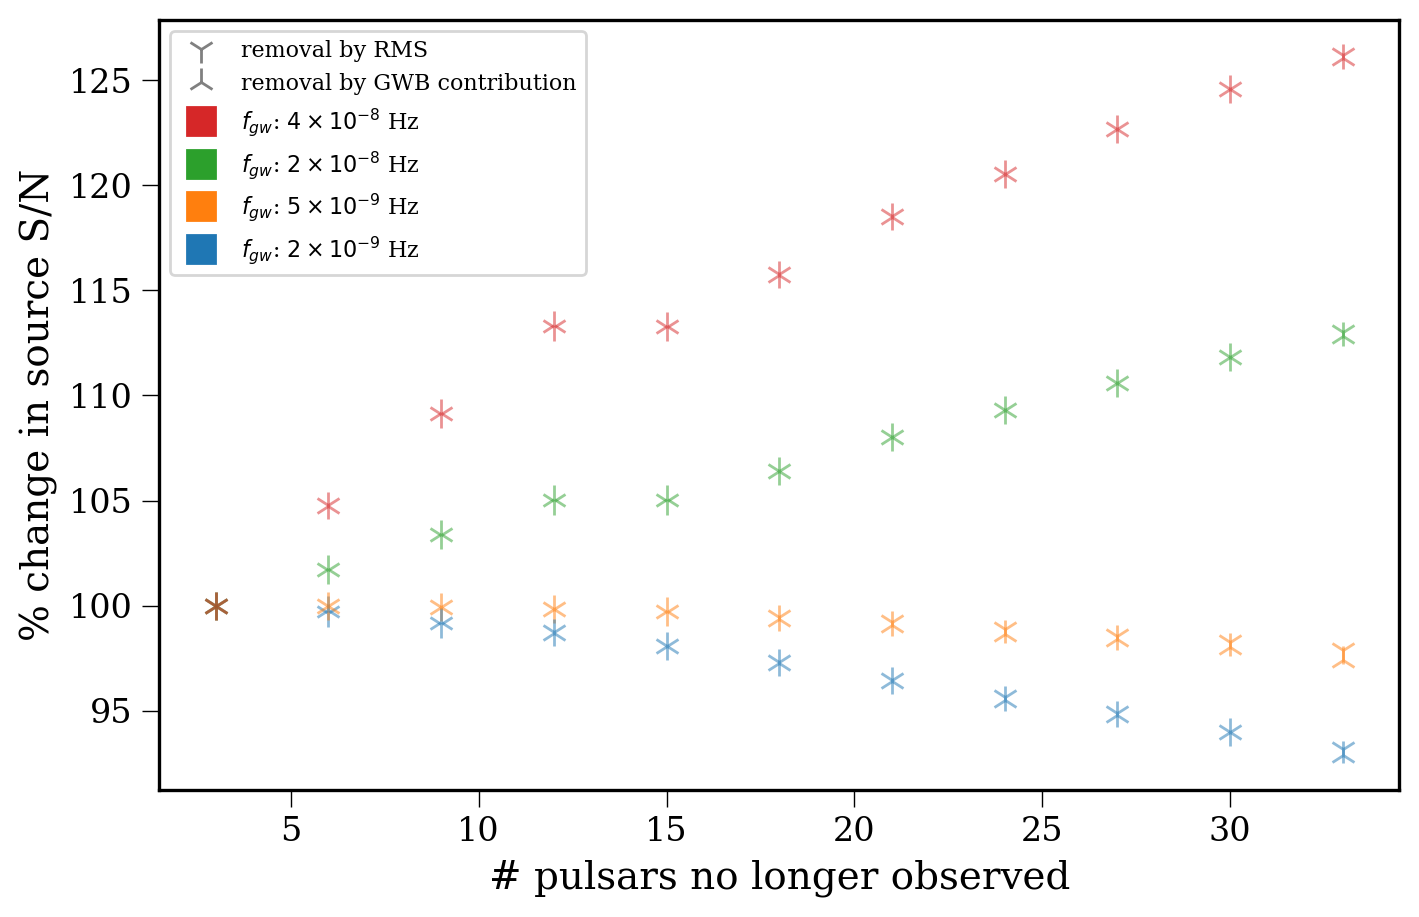

In [109]:
src_snr = np.array(SNRs).T
src_snr2 = np.array(SNRs2).T
dropped = 3*np.array([i for i in range(1,len(GWBSNRs)+1)])
fig = plt.figure(figsize=(8,5))
for i in range(len(SNRs[0])):
    plt.plot(dropped, 100*src_snr[i]/src_snr[i][0], marker='1', markersize=10, color=f"C{i}", label=f"source freq: {freqs[source_freqs[i]]:.1e} Hz", alpha = 0.5, linestyle='')
for i in range(len(SNRs2[0])):
    plt.plot(dropped, 100*src_snr2[i]/src_snr2[i][0], marker='2', markersize=10, color=f"C{i}", label=f"source freq: {freqs[source_freqs[i]]:.1e} Hz", alpha=0.5, linestyle='')
plt.xlabel("# pulsars no longer observed", fontsize=14)
plt.ylabel("% change in source S/N", fontsize=14)
legs = [mpl.lines.Line2D([0], [0], color='grey', linestyle='', marker='1', markersize=10, label = 'removal by RMS'),
        mpl.lines.Line2D([0], [0], color='grey', linestyle='', marker='2', markersize=10, label = 'removal by GWB contribution'),
        mpl.lines.Line2D([0], [0], color='C3', linestyle='', marker='s', markersize=10, label="$f_{gw}$: "+"${}$ Hz".format(f.format_data(h0_freqs[3]))),
        mpl.lines.Line2D([0], [0], color='C2', linestyle='', marker='s', markersize=10, label="$f_{gw}$: "+"${}$ Hz".format(f.format_data(h0_freqs[2]))),
        mpl.lines.Line2D([0], [0], color='C1', linestyle='', marker='s', markersize=10, label="$f_{gw}$: "+"${}$ Hz".format(f.format_data(h0_freqs[1]))),
        mpl.lines.Line2D([0], [0], color='C0', linestyle='', marker='s', markersize=10, label="$f_{gw}$: "+"${}$ Hz".format(f.format_data(h0_freqs[0]))),
        ]
plt.legend(handles=legs, fontsize=8, )
#plt.legend(loc=(0.01,0.75))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig(f'{fig_dir}/psr_dropping_src_snr_comp.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [110]:
source_freqs

[87, 129, 193, 225]

# 5) What if instead of completely dropping pulsars, we just half their cadence.
- The idea here is that their high sensitivity was probably so weak, they probably were not contributing there anyways.

In [112]:
# create modified campaign
hpsrs = reset_psrs()
#hpsrs = load_alpha_two_thirds_psrs()
start_year = 20
end_year = 30.1
cadence_factor = 4
thin_cadence_factor = 1/2
pulsars_dropped_per_year = (cadence_factor-1)/thin_cadence_factor
iterations = 10
pulsars_dropped_per_year


Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


6.0

In [113]:
pulsars_dropped_per_year = int(pulsars_dropped_per_year)

In [114]:
idx_best_to_worst = np.argsort([hpsrs[i].toaerrs[0] for i in range(len(hpsrs))])
# remove pulsars which come after the specified date
idx_best_to_worst_filtered = [ idx for idx in idx_best_to_worst if min(hpsrs[idx].toas)<=start_year*yr_sec ]
len(idx_best_to_worst_filtered)
hpsrs[idx_best_to_worst_filtered[0]].toaerrs[0], hpsrs[idx_best_to_worst_filtered[-1]].toaerrs[0] 
##### idx_best_to_worst_filtered from the GWB droupout
hpsrs = reset_psrs()
end_year = 30.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
dropout_GWB = []
#mask_template = [True for i in range(len(spectra))]
for idx in range(len(spectra)):
    mask = [True for i in range(len(spectra))] 
    mask[idx] = False
    dropout_GWB.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))

start_year = 20
hpsrs = reset_psrs()
dropout_GWB_sorted = np.flip(np.sort(dropout_GWB))
idx_sorted = [dropout_GWB.index(el) for el in dropout_GWB_sorted]
idx_sorted_filtered = [ idx for idx in idx_sorted if min(hpsrs[idx].toas)<=start_year*yr_sec ]

psrs_high_cad = idx_best_to_worst_filtered[:iterations]
psrs_removed = idx_sorted_filtered
psrs_high_cad, psrs_removed
#check that you are not removing and increasing cadence (intersection should be zero)
np.intersect1d(psrs_high_cad, psrs_removed[:iterations*pulsars_dropped_per_year])

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


array([], dtype=int64)

In [115]:
psrs_high_cad, np.array(psrs_removed)

([79, 53, 32, 3, 113, 77, 92, 102, 38, 82],
 array([  7,  17,  68,  56,  69,   9,  18,  28,   1,  43,  11,  40,  19,
         49,  64,  33,  88,  80,  14,  34,  89,  51,  62,  46,  84, 101,
         71,  97,  90,  22,  12,  35,  70, 114,  15,  10,  24,  78,  45,
         95, 109,  58, 105,  67,   6,  41,  74, 107,   5,  21,  85,  99,
         52,  26,  60,  96,  98,   0,  65,  37, 104,  16,  48,  47,  57,
         82,  87,   4, 108,  75, 112,   8,  59,   2,  61,  23,  83,  39,
        103, 102,  54,  63, 110,  81,  77,  86,  44,  27,  30,  20,  31,
        113,  93,  55, 106,  76,  94,  29,  91,  92,  53,  42,  13,  50,
         72,  38,  36,  32,  25,  73,  79, 111, 100,   3,  66]))

In [116]:
GWBSCs = []
GWBSNRs = []
SNRs = []
SMs = []
hpsrs = reset_psrs()
noise_before = {}
noise_after = {}
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs.append(GWBSCs[-1].SNR(S_h))
SNRs.append([0.5*SMs[-1].SNR(h_0) for h_0 in source_h0s])
for i, psr_hcad in enumerate(psrs_high_cad): # # enumerate([psrs_high_cad[0]]):
    # reduce pulsars with .filter_data() function
    for idx in range(pulsars_dropped_per_year):
        print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[psrs_removed[i*pulsars_dropped_per_year+idx]].name)
        hpsrs[psrs_removed[pulsars_dropped_per_year*i+idx]].change_cadence(
                start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=thin_cadence_factor, uneven=True,
                A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
        cadence=None, cadence_factor=cadence_factor, uneven=True,
        A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
        )
    # create psr spectra at end of cadence
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
    SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs.append(GWBSCs[-1].SNR(S_h))
    SNRs.append([0.5*SMs[-1].SNR(h_0) for h_0 in source_h0s])

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
1:1) reducing pulsar  J2223+0357
old: 551, new: 451
1:2) reducing pulsar  J0634+0328
old: 550, new: 449
1:3) reducing pulsar  J1015+0331
old: 791, new: 690
1:4) reducing pulsar  J0326+0145
old: 792, new: 692
1:5) reducing pulsar  J2154-0231
old: 691, new: 591
1:6) reducing pulsar  J1535-0011
old: 662, new: 561
quadrupuling pulsar  J1907-0212
toas before:  694
old: 694, new: 1293
PTA spectrum with 133 psrs created.
2:1) reducing pulsar  J1135+0251
old: 684, new: 584
2:2) reducing pulsar  J2100-0048
old: 557, new: 457
2:3) reducing pulsar  J2052+0211
old: 550, new: 450
2:4) reducing pulsar  J1514-0303
old: 646, new: 546
2:5) reducing pulsar  J0122-0052
old: 566, new: 466
2:6) reducing pulsar  J2028-0020
old: 789, new: 689
quadrupuling pulsar  J1900-0226
toas before:  562
old: 562, new: 1159
PTA spectrum with 133 psrs created.
3:1) reducing pulsar  J1726+0347
old: 658, new: 558
3:2) reducing puls

In [121]:

GWBSNRs


[22.49397805722628,
 22.478086674410026,
 22.440369679686288,
 22.360259454845977,
 22.285668056563217,
 22.205243170432524,
 22.038201230644237,
 21.958848528605905,
 21.81500937905801,
 21.67804456489585,
 21.575278319626758]

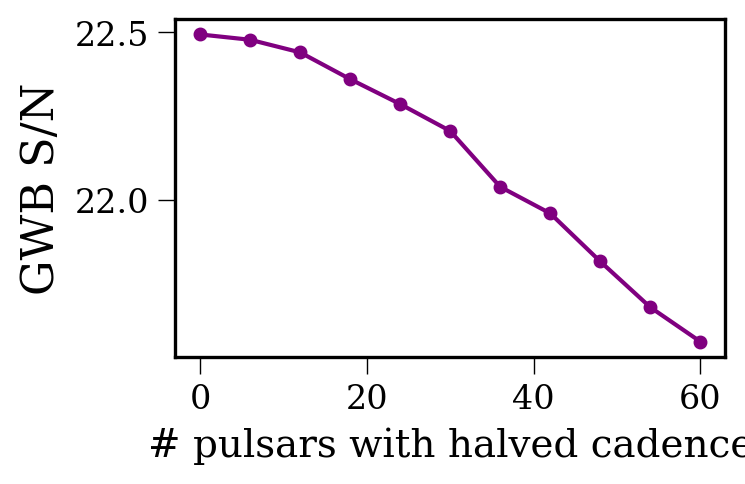

In [122]:

dropped = pulsars_dropped_per_year* np.array([i for i in range(0,len(SNRs))])
plt.plot(dropped, GWBSNRs, marker='o', color="purple")
#plt.title(f"GWB S/N x1/2 cad 6N-worst psrs & x4 cad N-best psrs {start_year}->{end_year}")
plt.xlabel("# pulsars with halved cadence", fontsize=14)
plt.ylabel("GWB S/N", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig(f'{fig_dir}/alt_camp_half_cad_gwb_snr.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()


In [119]:
# # Plot skymap SC
# f = ticker.ScalarFormatter(useMathText=True)
# f.set_powerlimits((-3,3))
# dropped = pulsars_dropped_per_year*np.array([i for i in range(0,len(SNRs))])
# color_map = sns.color_palette("coolwarm", as_cmap=False, n_colors=len(dropped))
# #color_map = sns.diverging_palette(10, 250, as_cmap=False, n = len(dropped), center='dark')
# #color_map = sns.dark_palette("seagreen", as_cmap=False, n_colors=len(dropped))
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', np.flip(color_map, axis=0), len(color_map))
# fig = plt.figure(figsize=[8,5])
# for i, sc in enumerate(SMs):
#     linewidth=1
#     #plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"x{cadence_factor} cad to {dropped[i]/3:.0f}psrs", color = color_map[i], linewidth=linewidth, alpha=0.75)
#     plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1.0)
# #plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
# for i in range(len(h0_freqs)):
#     plt.axvline(h0_freqs[i], linestyle='--', color=f'C{i}', linewidth=2)
# # plt.legend(
# #            loc='upper left', fontsize=10,
# #            )
# plt.xlabel('Frequency [Hz]', fontsize=14)
# plt.ylabel('Characteristic strain, $h_{c}$', fontsize=14)
# #plt.title(f'Sky-Aved. "white noise removal" @{end_year:.1f}yrs', fontsize = 24)
# plt.grid(which='both')
# plt.xlim((1e-9, 1e-7))
# plt.ylim((3e-15, 2e-13))
# #plt.legend([],loc=(0.07, 0.22), prop={'size':275}, alpha=0.75)
# plt.legend([],bbox_to_anchor=(.01, 0.99), loc='upper left', facecolor='white', fancybox=True, borderpad=16)#borderpad=10)
# #### make the inset plot
# left, bottom, width, height = [0.215, 0.35, 0.3, 0.45]
# ax3 = fig.add_axes([left, bottom, width, height])
# ax3.plot()
# SNRs = []
# for i in range(len(GWBSNRs)):
#     SNRs.append([0.5*np.mean(SMs[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])
# src_snr = np.array(SNRs).T
# markerss= ['1', '2', 'o', 'o']
# sizess = [8,8,6,6]
# for i in np.flip(range(len(SNRs[0]))):
#     ax3.plot(dropped, 100*src_snr[i]/src_snr[i][0], marker=markerss[i], markersize= sizess[i], color=f'C{i}',#color=source_colors[i],
#              label=r"$f_{\rm gw}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])),
#              linestyle='-', alpha=1)
# ax3.set_xlabel('# pulsars on low cadence', fontsize=8)
# ax3.set_ylabel("% standard campaign S/N", fontsize=8)
# ax3.legend(fontsize=6.25)
# #### make the color bar
# ax2 = fig.add_axes([0.99, 0.1, 0.03, 0.78])
# norm = mpl.colors.BoundaryNorm(np.flip(dropped), cmap.N)
# cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
#     spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(dropped),ticklocation='right')
# #ax2.set_ylabel('# pulsars on low cadence', fontsize=12)
# ax2b = cbar.ax.twinx()
# norm = mpl.colors.BoundaryNorm(np.flip(GWBSNRs), cmap.N)
# mpl.colorbar.ColorbarBase(ax2b, cmap=cmap, format='%.1f', norm=norm, boundaries=np.flip(GWBSNRs))
# ax2.set_ylabel('GWB S/N', fontsize=12, labelpad=37)
# ax2b.set_ylabel('# pulsars on low cadence', fontsize=12, labelpad=-87)
# for label in ax2.get_yticklabels(minor=True):
#     label.set_verticalalignment('center')
# plt.savefig(f'{fig_dir}/alt_camp_half_cad_sc.pdf', dpi=600, bbox_inches='tight', facecolor='white')
# plt.show()
# plt.close()

In [123]:
SNRs = []
for i in range(len(GWBSNRs)):
    SNRs.append([np.mean(SMs[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])
src_snr = np.array(SNRs).T
snr_3sig = 3.7145
detvol1 = np.array([calculate_detection_volume(SM,SNR_threshold=snr_3sig, frequency=freqs[source_freqs],M_c=1e9) for _, SM in enumerate(SMs)]).T

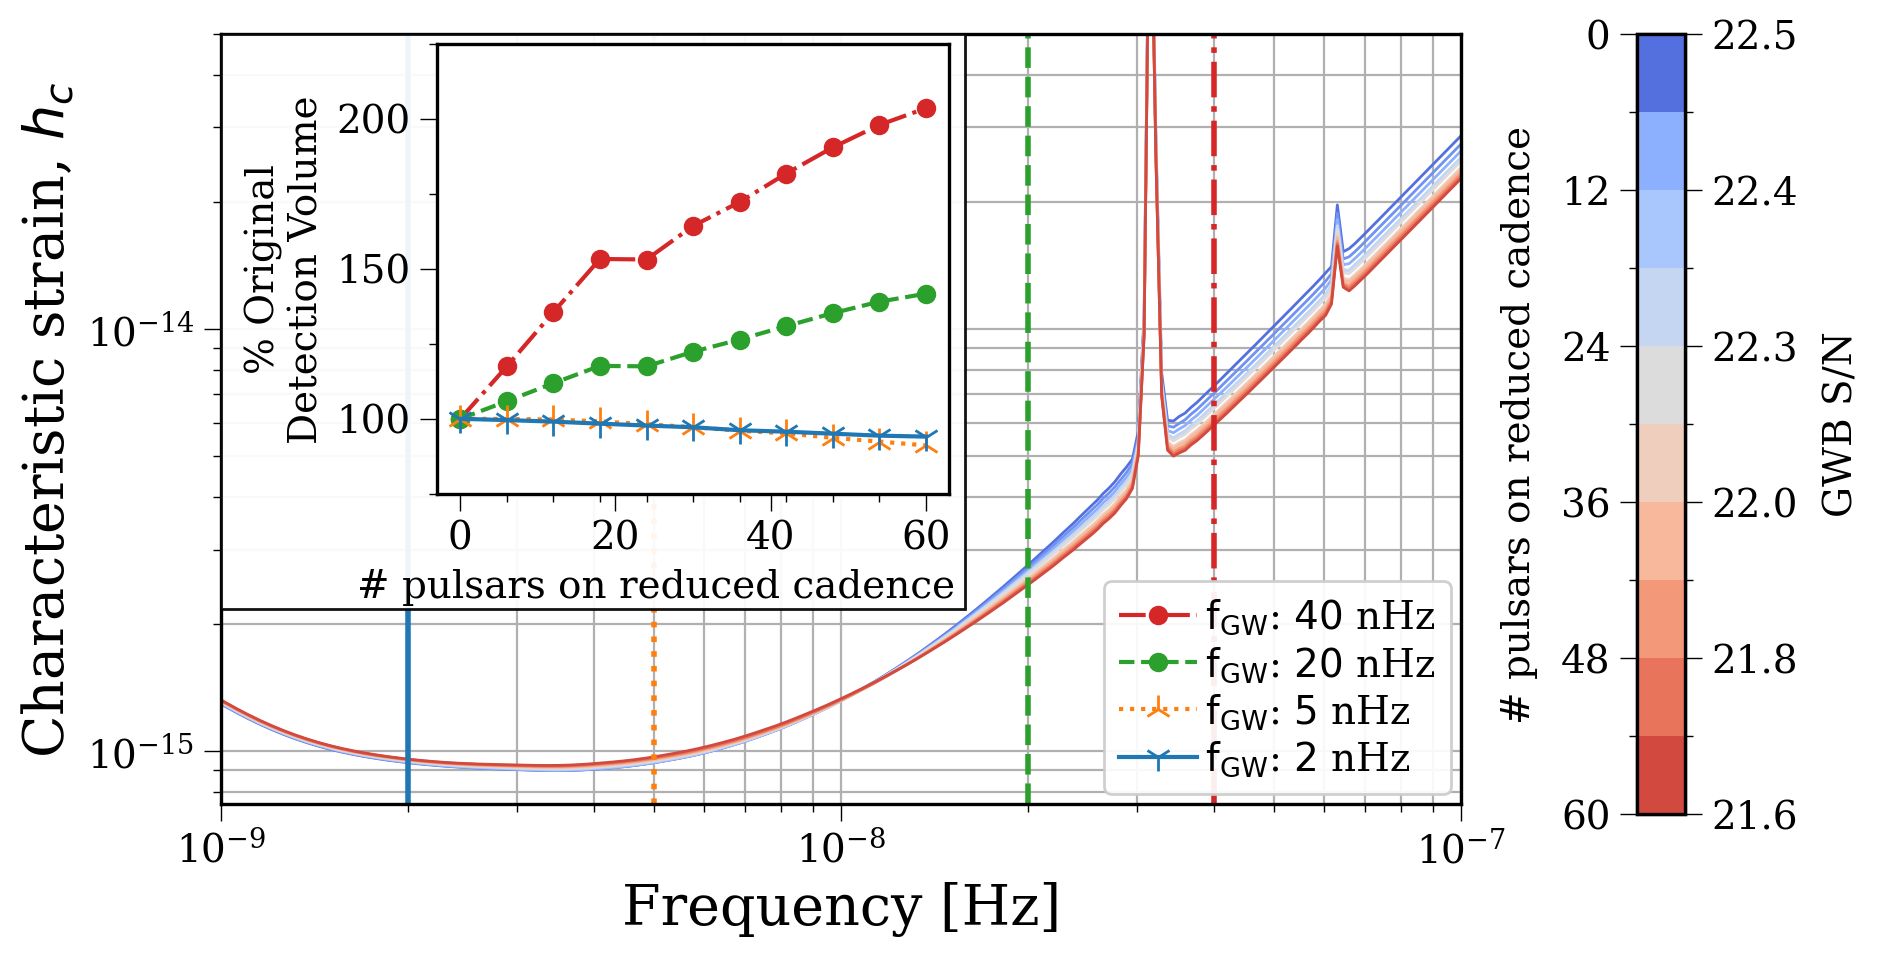

In [127]:
# Plot skymap SC
nhz = [int(h0_freqs[i]/1e-9) for i in range(4)] 
f = ticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-3,3))
dropped = pulsars_dropped_per_year*np.array([i for i in range(0,len(SNRs))])
color_map = sns.color_palette("coolwarm", as_cmap=False, n_colors=len(dropped))
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', np.flip(color_map, axis=0), len(color_map))
linestyles=['solid', 'dotted', 'dashed', 'dashdot']
fig = plt.figure(figsize=[8,5])
ax1 = fig.add_subplot(1,1,1,zorder=0)
for i, sc in enumerate(SMs):
    linewidth=1
    plt.loglog(sc.freqs, np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1.0)
plt.loglog(freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
for i in range(len(h0_freqs)):
    plt.axvline(h0_freqs[i], linestyle=linestyles[i], color=f'C{i}', linewidth=2, )#label=r"$\rm f_{GW}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])))
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Characteristic strain, $h_{c}$', fontsize=20)
plt.grid(which='both')
plt.xlim((1e-9, 1e-7))
plt.ylim((3e-15/4, 2e-13/4))
plt.legend(handles=ax3.get_children()[0:4], loc=(0.712,0.0125), fontsize=14,framealpha=0.925, labelspacing=0.2, handletextpad=0.2)
# the below is a legend just to shade out the region behind the plot
#plt.legend([],bbox_to_anchor=(.01, 0.99), loc='upper left', facecolor='white', fancybox=True, borderpad=16)#borderpad=10)
loc_box = [0.0, 0.253, 0.6, 1-0.253]
buffer=0.0
#### make the inset plot background
ax1.add_patch(plt.Rectangle((
    loc_box[0]-buffer, loc_box[1]-buffer,), 
    loc_box[2]+buffer, loc_box[3]+buffer, 
    linestyle="-", edgecolor="k", facecolor="w", 
    linewidth=1, alpha=0.93,zorder=21, #zorder=5, 
    transform=ax1.transAxes))
left, bottom, width, height = [0.26, 0.42, 0.32, 0.45]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.plot()
markerss= ['1', '2', 'o', 'o']
sizess = [10,10,6,6]
for i in np.flip(range(len(SNRs[0]))):
    ax3.plot(dropped, 100*detvol1[i]/detvol1[i][0], marker=markerss[i],markersize=sizess[i], color=f"C{i}", label=r"$\rm f_{GW}$: "+"${}$ nHz".format(nhz[i]), linestyle=linestyles[i])
    # ax3.plot(dropped, 100*src_snr[i]/src_snr[i][0], marker='o', color=f'C{i}',#color=source_colors[i],
    #          label="$f_{gw}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])))
ax3.set_xlabel('# pulsars on reduced cadence      ', fontsize=14)
ax3.set_ylabel("% Original\nDetection Volume", fontsize=14)
ax3.set_yticks([75,100,125,150,175,200,225],minor=True)
ax3.set_xticks(dropped,minor=True)
# ax3.set_xticks()
#ax3.legend(fontsize=6)
#### make the color bar
ax2 = fig.add_axes([1.01, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(np.flip(dropped), cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(dropped),ticklocation='right')
#ax2.set_ylabel('# pulsars no longer observed', fontsize=12)
ax2b = cbar.ax.twinx()
norm = mpl.colors.BoundaryNorm(np.flip(GWBSNRs), cmap.N)
mpl.colorbar.ColorbarBase(ax2b, cmap=cmap, format='%.1f', norm=norm, boundaries=np.flip(GWBSNRs))
ax2.set_ylabel('GWB S/N', fontsize=14, labelpad=50)
ax2b.set_ylabel('# pulsars on reduced cadence', fontsize=14, labelpad=-107)
for label in ax2.get_yticklabels(minor=True):
    label.set_verticalalignment('center')
#plt.savefig(f'{fig_dir}/alt_camp_half_cad_sc.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

In [50]:
# # Plot skymap SC
# color_map = plt.cm.jet_r(np.linspace(0,1,len(SMs)))
# plt.figure(figsize=[8,5])
# for i, sc in enumerate(SMs):
#     linewidth=1
#     plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"x{cadence_factor} cad to {dropped[i]/3:.0f}psrs", color = color_map[i], linewidth=linewidth, alpha=0.75)
# #plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
# for i in range(len(h0_freqs)):
#     plt.axvline(h0_freqs[i], linestyle='--', color=f'C{i}', linewidth=2)
# plt.legend(
#            loc='upper left', fontsize=10,
#            )
# plt.xlabel('Frequency [Hz]', fontsize=16)
# plt.ylabel('$h_{c}$', fontsize=16)
# #plt.title(f'Sky-Aved. alt campaign @{end_year:.1f}yrs', fontsize = 24)
# plt.grid(which='both')
# plt.xlim((4e-10, 1e-7))
# plt.ylim((2e-15, 8e-13))
# plt.savefig(f'{fig_dir}/alt_camp_half_cad_sc.png', dpi=600, bbox_inches='tight', facecolor='white')
# plt.show()


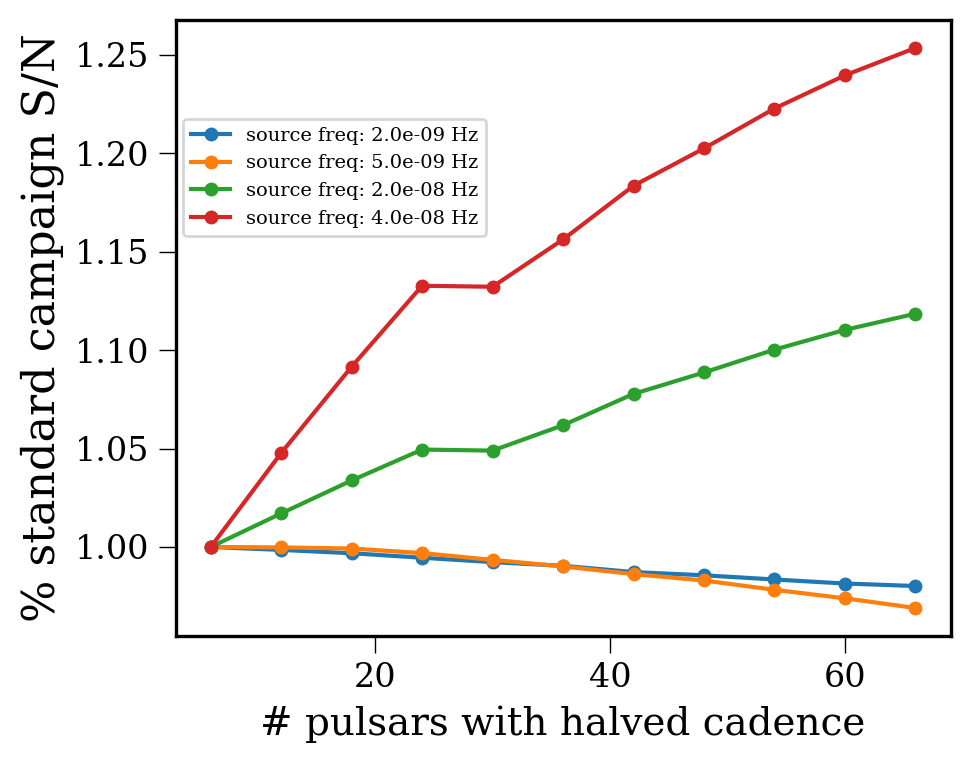

In [128]:

SNRs = []
for i in range(len(GWBSNRs)):
    SNRs.append([np.mean(SMs[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])
src_snr = np.array(SNRs).T
dropped = pulsars_dropped_per_year*np.array([i for i in range(1,len(GWBSNRs)+1)])
fig=plt.figure(figsize=(5,4))
for i in range(len(SNRs[0])):
    plt.plot(dropped, src_snr[i]/src_snr[i][0], marker='o', color=f"C{i}", label=f"source freq: {freqs[source_freqs[i]]:.1e} Hz")
#plt.title("Source S/N swapping 3psr for a x4 high cadence, yr 20->30")
plt.xlabel("# pulsars with halved cadence", fontsize=14)
plt.ylabel("% standard campaign S/N", fontsize=16)
plt.legend(loc=(0.01,0.65))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(f'{fig_dir}/alt_camp_half_cad_src_snr.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

# 7) What if we didn't drop any pulsars? we just had extra observing time

In [129]:
# create modified campaign
hpsrs = reset_psrs()
#hpsrs = load_alpha_two_thirds_psrs()
start_year = 20
end_year = 30.1
cadence_factor = 4
thin_cadence_factor = 1/2
pulsars_dropped_per_year = (cadence_factor-1)/thin_cadence_factor
pulsars_dropped_per_year


Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


6.0

In [130]:
pulsars_dropped_per_year = int(pulsars_dropped_per_year)

In [131]:

idx_best_to_worst = np.argsort([hpsrs[i].toaerrs[0] for i in range(len(hpsrs))])
# remove pulsars which come after the specified date
idx_best_to_worst_filtered = [ idx for idx in idx_best_to_worst if min(hpsrs[idx].toas)<=start_year*yr_sec ]
len(idx_best_to_worst_filtered)
hpsrs[idx_best_to_worst_filtered[0]].toaerrs[0], hpsrs[idx_best_to_worst_filtered[-1]].toaerrs[0] 
##### idx_best_to_worst_filtered from the GWB droupout
hpsrs = reset_psrs()
end_year = 30.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
dropout_GWB = []
#mask_template = [True for i in range(len(spectra))]
for idx in range(len(spectra)):
    mask = [True for i in range(len(spectra))] 
    mask[idx] = False
    dropout_GWB.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))

start_year = 20
hpsrs = reset_psrs()
dropout_GWB_sorted = np.flip(np.sort(dropout_GWB))
idx_sorted = [dropout_GWB.index(el) for el in dropout_GWB_sorted]
idx_sorted_filtered = [ idx for idx in idx_sorted if min(hpsrs[idx].toas)<=start_year*yr_sec ]

psrs_high_cad = idx_best_to_worst_filtered[:10]
psrs_removed = idx_sorted_filtered
psrs_high_cad, psrs_removed


Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


([79, 53, 32, 3, 113, 77, 92, 102, 38, 82],
 [7,
  17,
  68,
  56,
  69,
  9,
  18,
  28,
  1,
  43,
  11,
  40,
  19,
  49,
  64,
  33,
  88,
  80,
  14,
  34,
  89,
  51,
  62,
  46,
  84,
  101,
  71,
  97,
  90,
  22,
  12,
  35,
  70,
  114,
  15,
  10,
  24,
  78,
  45,
  95,
  109,
  58,
  105,
  67,
  6,
  41,
  74,
  107,
  5,
  21,
  85,
  99,
  52,
  26,
  60,
  96,
  98,
  0,
  65,
  37,
  104,
  16,
  48,
  47,
  57,
  82,
  87,
  4,
  108,
  75,
  112,
  8,
  59,
  2,
  61,
  23,
  83,
  39,
  103,
  102,
  54,
  63,
  110,
  81,
  77,
  86,
  44,
  27,
  30,
  20,
  31,
  113,
  93,
  55,
  106,
  76,
  94,
  29,
  91,
  92,
  53,
  42,
  13,
  50,
  72,
  38,
  36,
  32,
  25,
  73,
  79,
  111,
  100,
  3,
  66])

In [132]:
GWBSCs = []
GWBSNRs = []
SNRs = []
SMs = []
hpsrs = reset_psrs()
noise_before = {}
noise_after = {}
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs.append(GWBSCs[-1].SNR(S_h))
SNRs.append([SMs[-1].SNR(h_0) for h_0 in source_h0s])
for i, psr_hcad in enumerate(psrs_high_cad): # # enumerate([psrs_high_cad[0]]):
    # reduce pulsars with .filter_data() function
#     for idx in range(pulsars_dropped_per_year):
#         print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[psrs_removed[i*pulsars_dropped_per_year+idx]].name)
#         hpsrs[psrs_removed[pulsars_dropped_per_year*i+idx]].change_cadence(
#                 start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
#                 cadence=None, cadence_factor=thin_cadence_factor, uneven=False,
#                 A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
        cadence=None, cadence_factor=cadence_factor, uneven=True,
        A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
        )
    # create psr spectra at end of cadence
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
    SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs.append(GWBSCs[-1].SNR(S_h))
    SNRs.append([SMs[-1].SNR(h_0) for h_0 in source_h0s])

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


PTA spectrum with 133 psrs created.
quadrupuling pulsar  J1907-0212
toas before:  694
old: 694, new: 1293
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J1900-0226
toas before:  562
old: 562, new: 1159
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J2134-0018
toas before:  557
old: 557, new: 1156
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J2053-0059
toas before:  643
old: 643, new: 1240
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J2212-0045
toas before:  559
old: 559, new: 1156
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J0828-0210
toas before:  563
old: 563, new: 1162
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J1612-0200
toas before:  604
old: 604, new: 1203
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J1445+0220
toas before:  791
old: 791, new: 1390
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J1752+0422
toas before:  560
old: 560, new: 1157
PTA spectrum with 133 psrs created.
quadrupuli

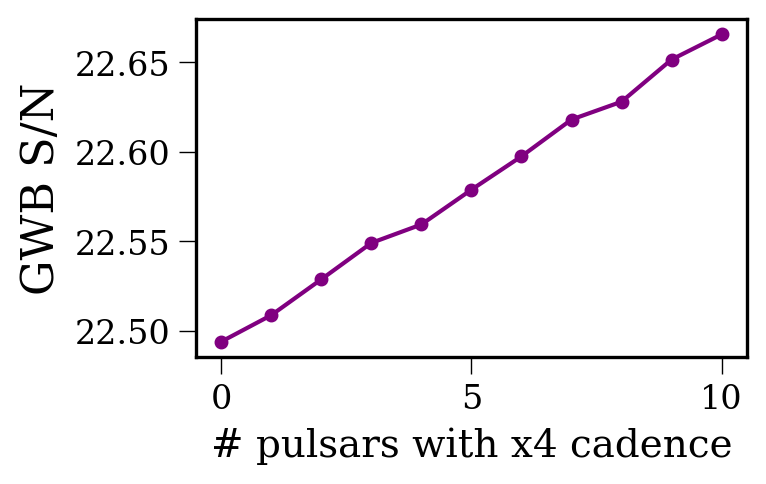

In [133]:
dropped = np.array([i for i in range(0,len(SNRs))])
plt.plot(dropped, GWBSNRs, marker='o', color="purple")
#plt.title(f"GWB S/N x1/2 cad 6N-worst psrs & x4 cad N-best psrs {start_year}->{end_year}")
plt.xlabel("# pulsars with x4 cadence", fontsize=14)
plt.ylabel("GWB S/N", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [212]:
GWBSNRs

[22.493978057225732,
 22.50866345268035,
 22.529506695583514,
 22.54944434409647,
 22.559402901217926,
 22.578963838570818,
 22.59654351572836,
 22.616129302641625,
 22.625690984196616,
 22.64916332205929,
 22.662565716664908,
 22.687355977738697,
 22.717946991151546]

In [134]:
SNRs = []
for i in range(len(GWBSNRs)):
    SNRs.append([np.mean(SMs[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])
src_snr = np.array(SNRs).T
snr_3sig = 3.7145
detvol1 = np.array([calculate_detection_volume(SM,SNR_threshold=snr_3sig, frequency=freqs[source_freqs],M_c=1e9) for _, SM in enumerate(SMs)]).T

In [137]:
# Plot skymap SC
nhz = [int(h0_freqs[i]/1e-9) for i in range(4)] 
f = ticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-3,3))
dropped = np.array([i for i in range(0,len(SNRs))])
color_map = sns.color_palette("coolwarm", as_cmap=False, n_colors=len(dropped))
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', np.flip(color_map, axis=0), len(color_map))
linestyles=['solid', 'dotted', 'dashed', 'dashdot']
fig = plt.figure(figsize=[8,5])
ax1 = fig.add_subplot(1,1,1,zorder=0)
for i, sc in enumerate(SMs):
    linewidth=1
    plt.loglog(sc.freqs, np.mean(sc.h_c, axis=1), color = color_map[i], linewidth=linewidth, alpha=1.0)
plt.loglog(freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
for i in range(len(h0_freqs)):
    plt.axvline(h0_freqs[i], linestyle=linestyles[i], color=f'C{i}', linewidth=2, )#label=r"$\rm f_{GW}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])))
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Characteristic strain, $h_{c}$', fontsize=20)
plt.grid(which='both')
plt.xlim((1e-9, 1e-7))
plt.ylim((3e-15/4, 2e-13/4))
plt.legend(handles=ax3.get_children()[0:4], loc=(0.712,0.0125), fontsize=14,framealpha=0.925, labelspacing=0.2, handletextpad=0.2)
# the below is a legend just to shade out the region behind the plot
#plt.legend([],bbox_to_anchor=(.01, 0.99), loc='upper left', facecolor='white', fancybox=True, borderpad=16)#borderpad=10)
loc_box = [0.0, 0.253, 0.6, 1-0.253]
buffer=0.0
#### make the inset plot background
ax1.add_patch(plt.Rectangle((
    loc_box[0]-buffer, loc_box[1]-buffer,), 
    loc_box[2]+buffer, loc_box[3]+buffer, 
    linestyle="-", edgecolor="k", facecolor="w", 
    linewidth=1, alpha=0.93,zorder=21, #zorder=5, 
    transform=ax1.transAxes))
left, bottom, width, height = [0.26, 0.42, 0.32, 0.45]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.plot()
markerss= ['1', '2', 'o', 'o']
sizess = [10,10,6,6]
for i in np.flip(range(len(SNRs[0]))):
    ax3.plot(dropped, 100*detvol1[i]/detvol1[i][0], marker=markerss[i],markersize=sizess[i], color=f"C{i}", label=r"$\rm f_{GW}$: "+"${}$ nHz".format(nhz[i]), linestyle=linestyles[i])
    # ax3.plot(dropped, 100*src_snr[i]/src_snr[i][0], marker='o', color=f'C{i}',#color=source_colors[i],
    #          label="$f_{gw}$: "+"${}$ Hz".format(f.format_data(h0_freqs[i])))
ax3.set_xlabel('# pulsars on high cadence      ', fontsize=14)
ax3.set_ylabel("% Original\nDetection Volume", fontsize=14)
ax3.set_yticks([75,100,125,150,175,200,225],minor=True)
ax3.set_xticks(dropped,minor=True)
# ax3.set_xticks()
#ax3.legend(fontsize=6)
#### make the color bar
ax2 = fig.add_axes([0.945, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(np.flip(dropped), cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(dropped),ticklocation='right')
ax2.set_ylabel('# pulsars on high cadence', fontsize=14, labelpad=7)
for label in ax2.get_yticklabels(minor=True):
    label.set_verticalalignment('center')
#plt.savefig(f'{fig_dir}/alt_camp_x4cad_sc.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

In [135]:
# # Plot skymap SC
# color_map = plt.cm.jet_r(np.linspace(0,1,len(SMs)))
# plt.figure(figsize=[8,5])
# for i, sc in enumerate(SMs):
#     linewidth=1
#     plt.loglog(sc.freqs, 2*np.mean(sc.h_c, axis=1),label=f"x{cadence_factor} cad to {dropped[i]/3:.0f}psrs", color = color_map[i], linewidth=linewidth, alpha=0.75)
# #plt.loglog(yearly_GWBSC[0].freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = "injected GWB")
# for i in range(len(h0_freqs)):
#     plt.axvline(h0_freqs[i], linestyle='--', color=f'C{i}', linewidth=2)
# plt.legend(
#            loc='upper left', fontsize=10,
#            )
# plt.xlabel('Frequency [Hz]', fontsize=16)
# plt.ylabel('$h_{c}$', fontsize=16)
# #plt.title(f'Sky-Aved. alt campaign @{end_year:.1f}yrs', fontsize = 24)
# plt.grid(which='both')
# plt.xlim((4e-10, 1e-7))
# plt.ylim((2e-15, 8e-13))
# plt.savefig(f'{fig_dir}/alt_camp_x4cad_sc.png', dpi=600, bbox_inches='tight', facecolor='white')
# plt.show()


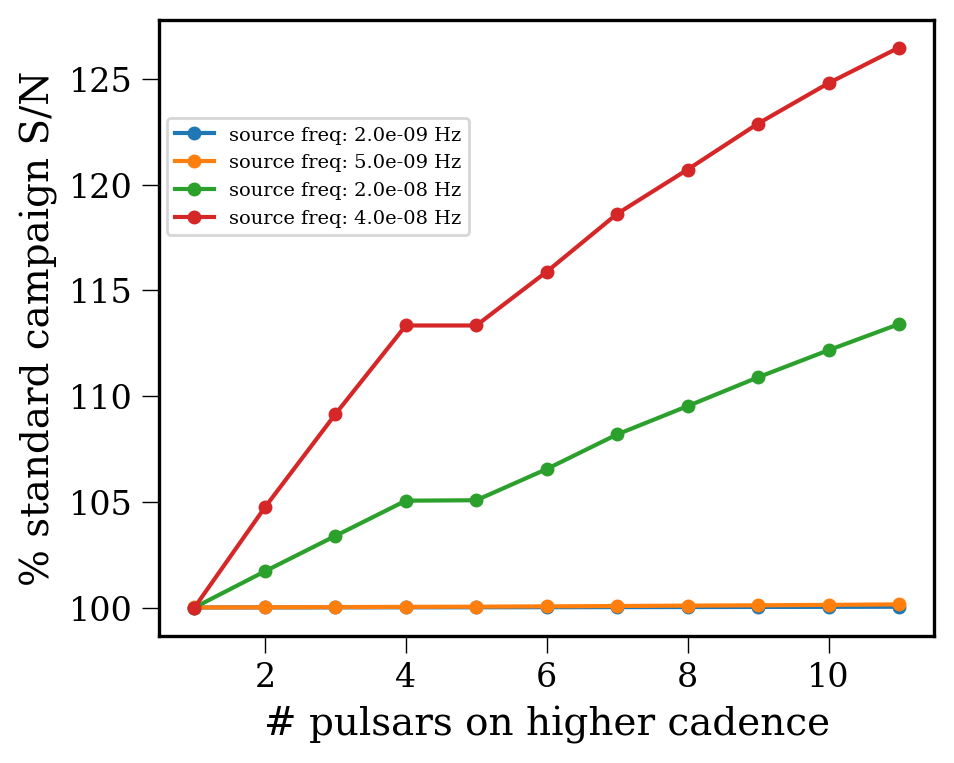

In [138]:

SNRs = []
fig = plt.figure(figsize=(5,4))
for i in range(len(GWBSNRs)):
    SNRs.append([np.mean(SMs[i].SNR(source_h0s[idx])[source_freqs[idx]]) for idx in range(len(source_h0s))])
src_snr = np.array(SNRs).T
dropped = np.array([i for i in range(1,len(GWBSNRs)+1)])
#print(len(dropped))
for i in range(len(SNRs[0])):
    plt.plot(dropped, 100*src_snr[i]/src_snr[i][0], marker='o', color=f"C{i}", label=f"source freq: {freqs[source_freqs[i]]:.1e} Hz")
#plt.title("Source S/N swapping 3psr for a x4 high cadence, yr 20->30")
plt.xlabel("# pulsars on higher cadence", fontsize=14)
plt.ylabel("% standard campaign S/N", fontsize=14)
plt.legend(loc=(0.01,0.65))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(f'{fig_dir}/alt_camp_x4_cad_src_snr.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()